# 은행 이탈 데이터 셋을 이용한 이진 분류

## 1. 문제 정의(개요)
은행 고객 이탈 예측 관련 데이터셋을 사용해 이진 분류 모델을 구축하는 것을 목적으로 합니다. 이 데이터셋에는 고객ID, 이름, 신용점수, 국가, 성별, 나이, 보유기간, 잔액, 제품 수, 신용카드 상태, 활성 멤버쉽, 예상 급여 및 이 데이터 셋의 메인 학습 라벨인 고객 이탈 여부 등 다양한 특성들이 포함되어 있습니다. 이 프로젝트는 데이터 탐색, 전처리, 모델 선택 및 훈련, 모델 평가, 결과 시각화, 배포의 단계로 진행됩니다. 주어진 데이터를 가지고 모델을 학습시켜 고객의 이탈 예측 및 방지를 목표로 두고 있습니다.

In [52]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import joblib
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from lightgbm import early_stopping
from visualization import *

In [16]:
train_df = pd.read_csv('C:/Users/jeonghwanlee/Downloads/train.csv')
origin_df = pd.read_csv('C:/Users/jeonghwanlee/Downloads/Churn_Modelling.csv')
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


## 2. 데이터 전처리

### - 데이터 확인

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [8]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


### 👀 Features:

- id: 인덱스 
- CustomerId: 고객 id
- Surname: 고객의 성
- CreditScore: 신용 점수
- Geography: 거주 지역
- Gender: 성별
- Age: 나이
- Tenure: 가입년수
- Balance: 계좌 잔액
- NumOfProducts: 가입 상품 수
- HasCrCard: 신용카드 여부
- IsActiveMember: 활성화된 회원 여부
- EstimatedSalary:  예상 급여
- Exited:  이탈여부

- HasCrCard, IsActiveMember는 숫자로 되어 있지만 실질적으로는 범주형 데이터로 고려
- id, CustomerID, Surname은 데이터를 특정하고 분석에 의미를 갖지 않기 때문에 분석에서 제외

> 범주형 데이터
- Geography, Gender, HasCrCard, IsActiveMember
> 수치형 데이터
- CreditScore, Age, Tenure, Balance, EstimatedSalary, NumOfProducts
> 타겟
- Exited

<Axes: >

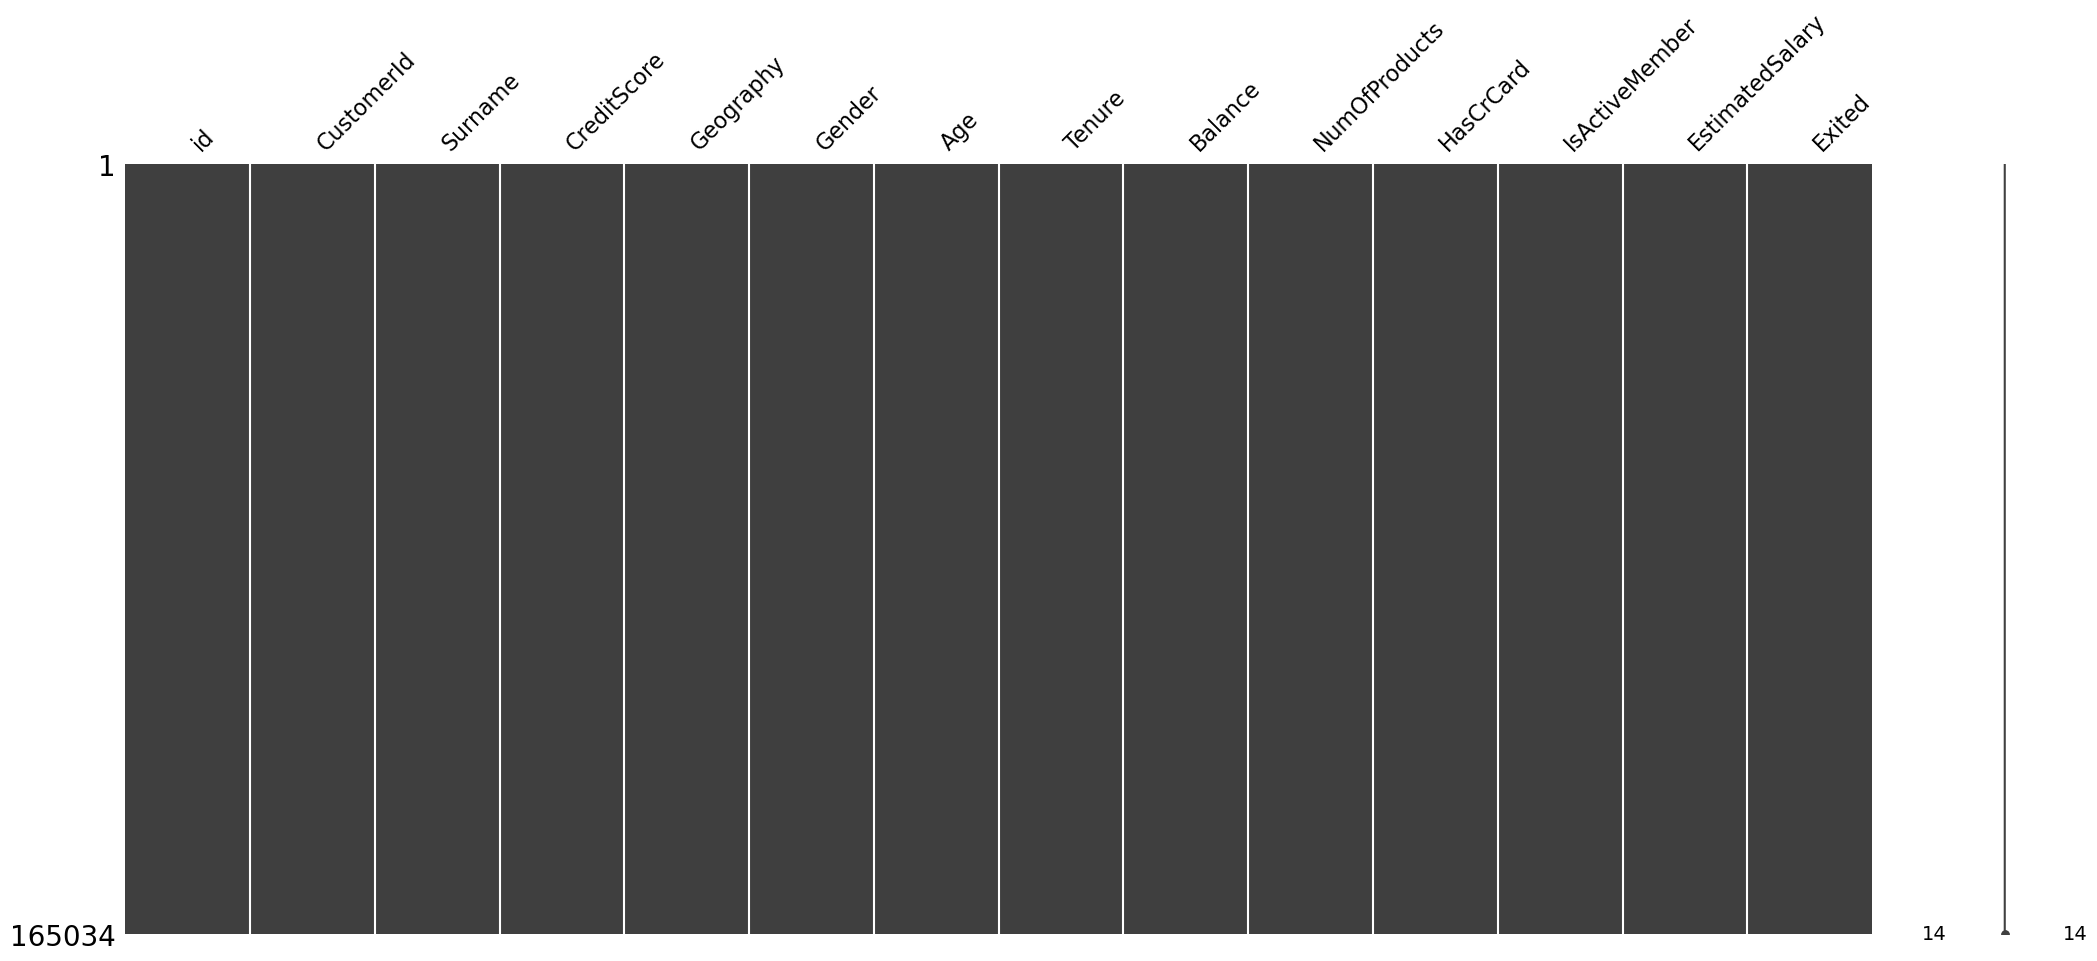

In [9]:
msno.matrix(train_df)

### 데이터 중복행 삭제

In [10]:
# 중복행 확인
train_df = train_df.drop(['id','Surname'], axis=1)
train_df.duplicated().sum()

30

In [22]:
train_duplicated  = train_df[train_df.duplicated(keep=False)].head(25)
train_duplicated.loc[[3308,57710]]

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3308,15634281,720,Germany,Female,43.0,10,110822.9,1,0.0,0.0,72861.94,1
57710,15634281,720,Germany,Female,43.0,10,110822.9,1,0.0,0.0,72861.94,1


In [23]:
# 중복행 삭제
train_df.drop_duplicates(inplace = True)
train_df.dropna(inplace=True)

## 3. 데이터 EDA(Train 데이터)

###  - 타켓 컬럼 비율 확인

In [26]:
# 시각화 위한 일시적 처리
train_df["Exited"]=train_df["Exited"].map({0: "No",1: "Yes"})

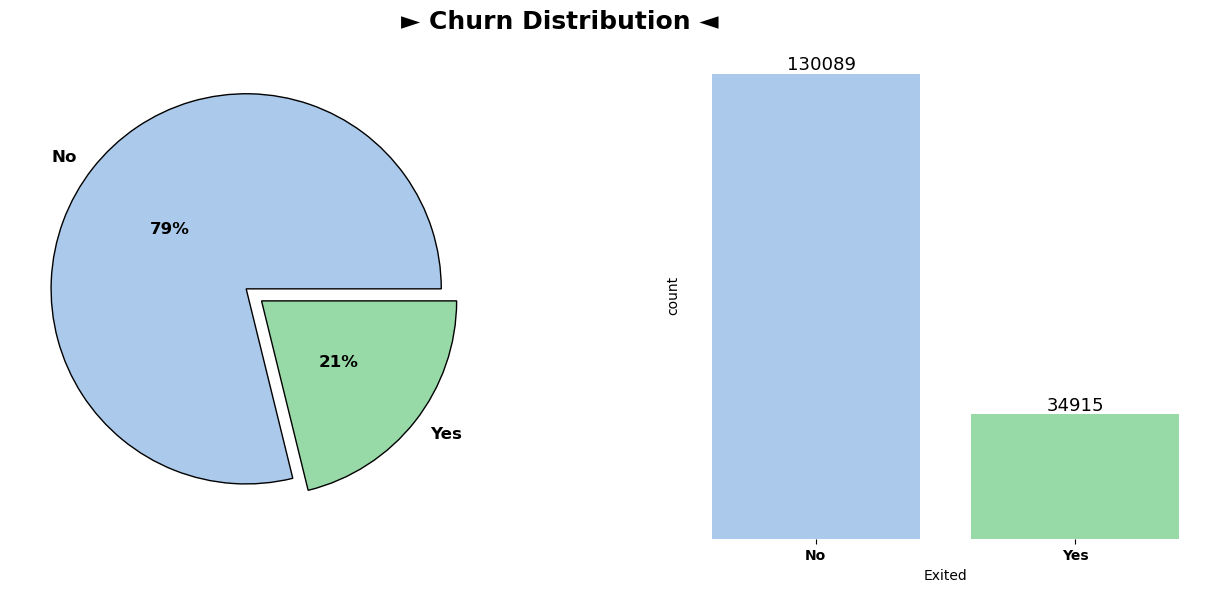

In [27]:
def plot_target(df: pd.DataFrame, col: str, title: str, pie_colors:list) -> None:
    fig, ax = plt.subplots(1,2,figsize=(15, 6), width_ratios=[2,1])

    textprops={'fontsize': 12, 'weight': 'bold',"color": "black"}
    ax[0].pie(df[col].value_counts().to_list(),
            colors=pie_colors,
            labels=df[col].value_counts().index.to_list(),
            autopct='%1.f%%', 
            explode=([.05]*df[col].nunique()),
            pctdistance=0.5,
            wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
            textprops=textprops)

    sns.countplot(x = col, data=df, palette = "pastel6", order=df[col].value_counts().to_dict().keys())
    for p, count in enumerate(df[col].value_counts()):
        ax[1].text(p-0.11, count+np.sqrt(count)+1000, count, color='black', fontsize=13)
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    plt.yticks([])
    plt.box(False)
    fig.suptitle(x=0.56, t=f'► {title} Distribution ◄', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_target(train_df, 
            col="Exited", 
            title="Churn", 
            pie_colors=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])

> 타겟이 되는 Exited의 값이 8:2로 불균형함
- 향후 모델링 과정에서 문제를 해결하기 위한 여러 불균형 해소 방법 고려

### -  각각의 컬럼 내 값 비율 단순 분석

In [28]:
# 범주형/수치형 컬럼 구분
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

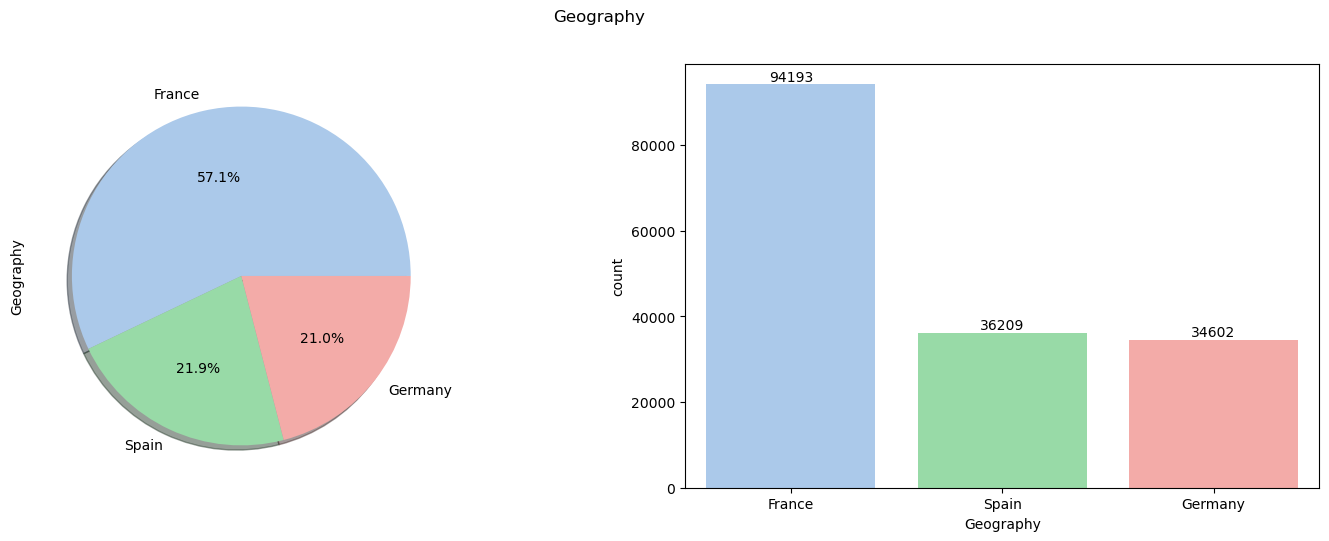

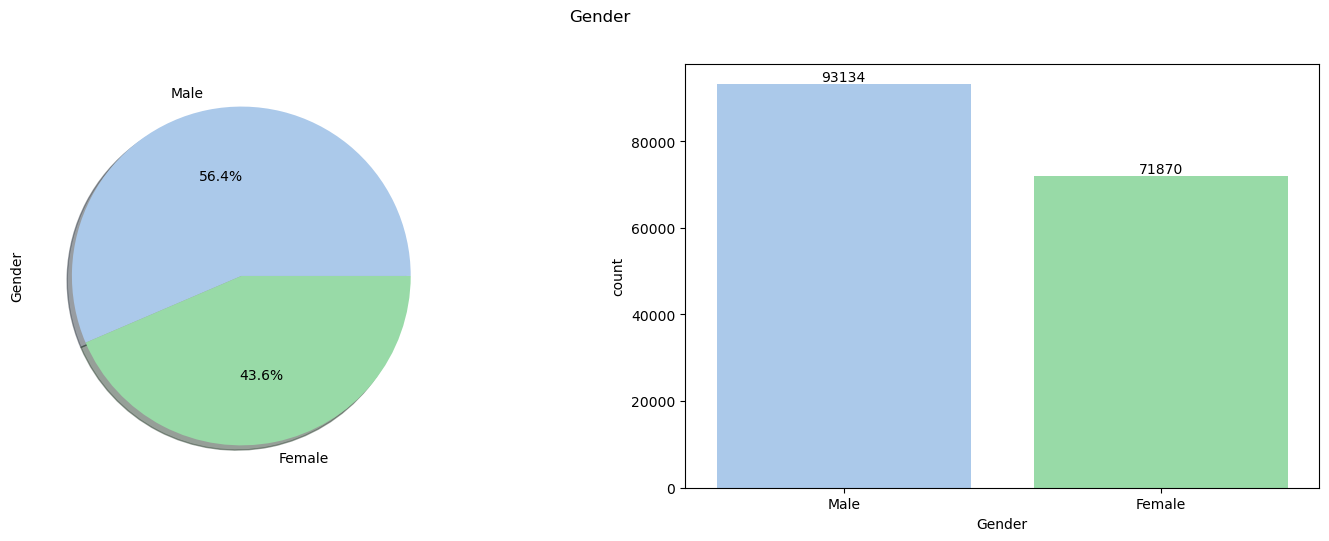

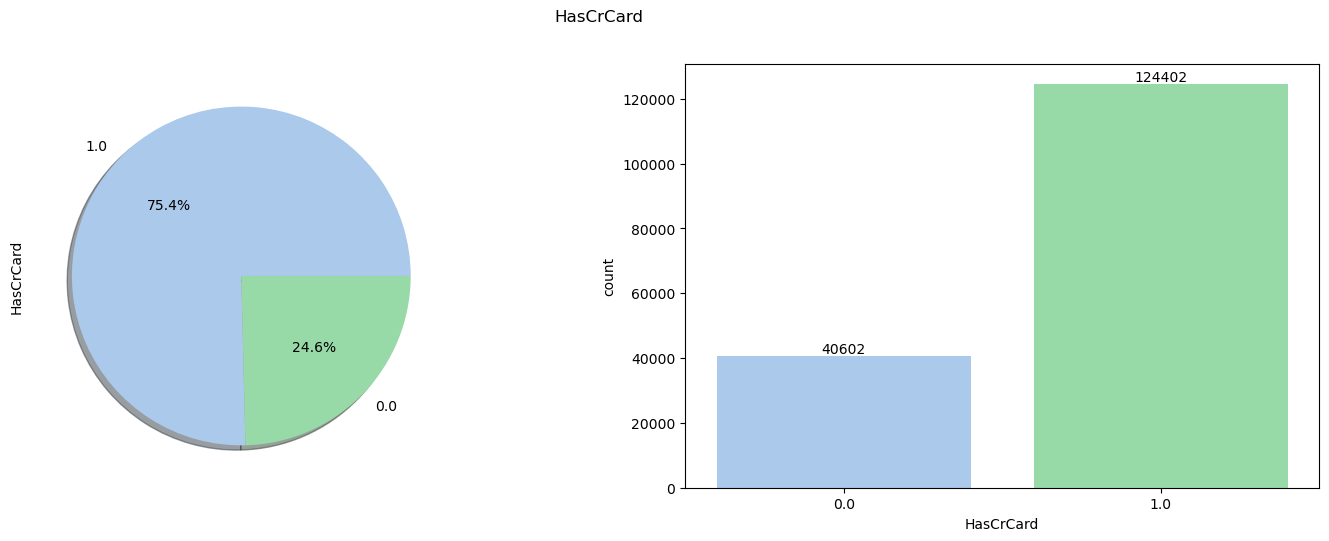

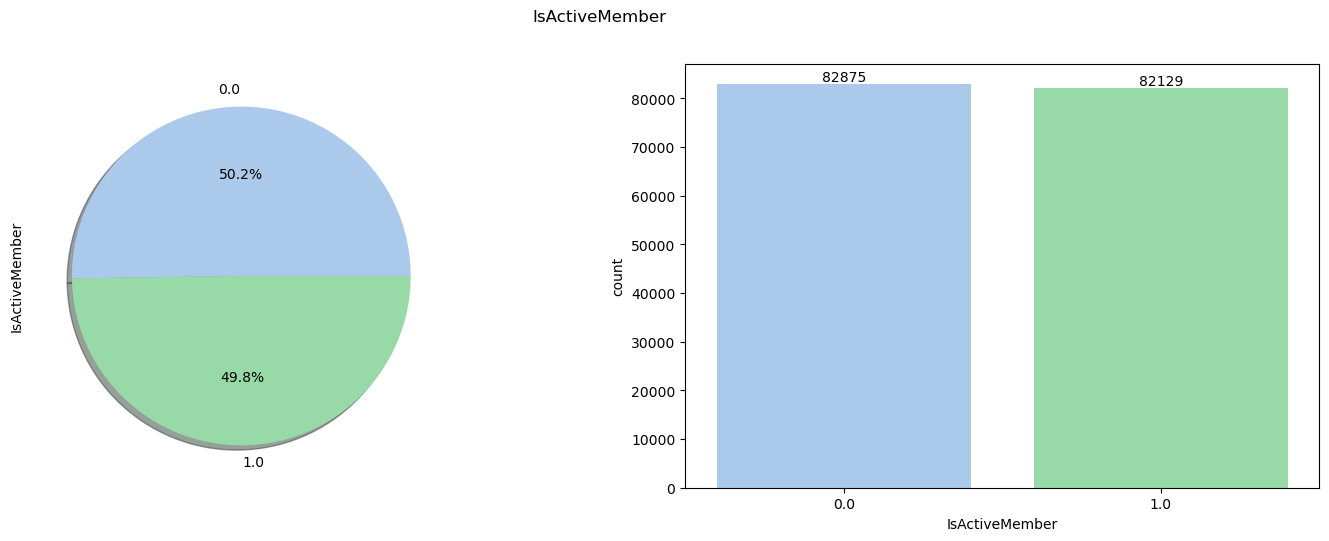

In [29]:
for column in cat_cols:
    f,ax=plt.subplots(1,2,figsize=(18,5.5))
    train_df[column].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True, colors =["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])
    ax[0].set_ylabel(f'{column}')
    
    sns.countplot(x=column,data=train_df,ax=ax[1],palette='pastel6')
    ax[1].bar_label(ax[1].containers[0])
    plt.suptitle(f'{column}')
    plt.show()

In [49]:
train_df["Exited"]=train_df["Exited"].map({"No": 0,"Yes": 1})

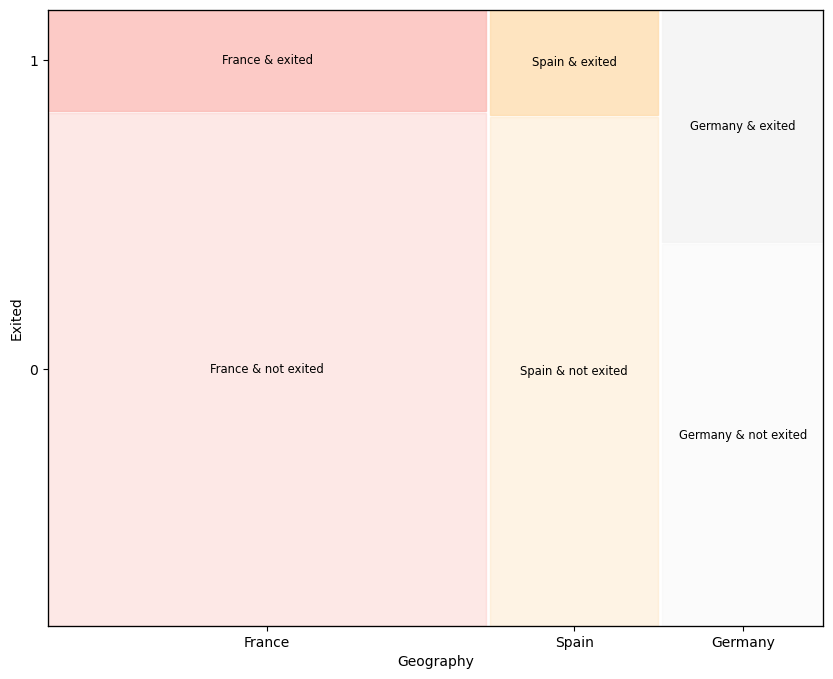

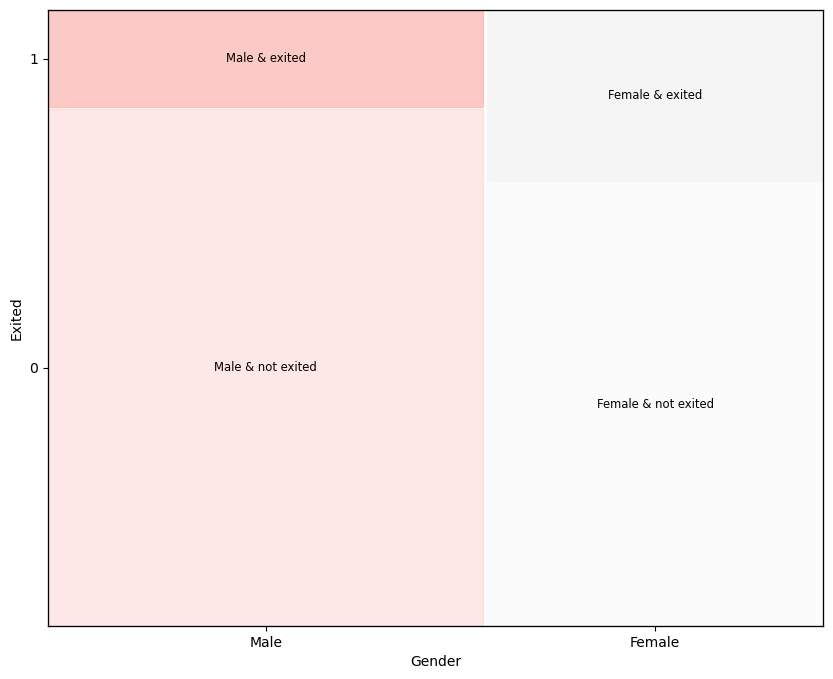

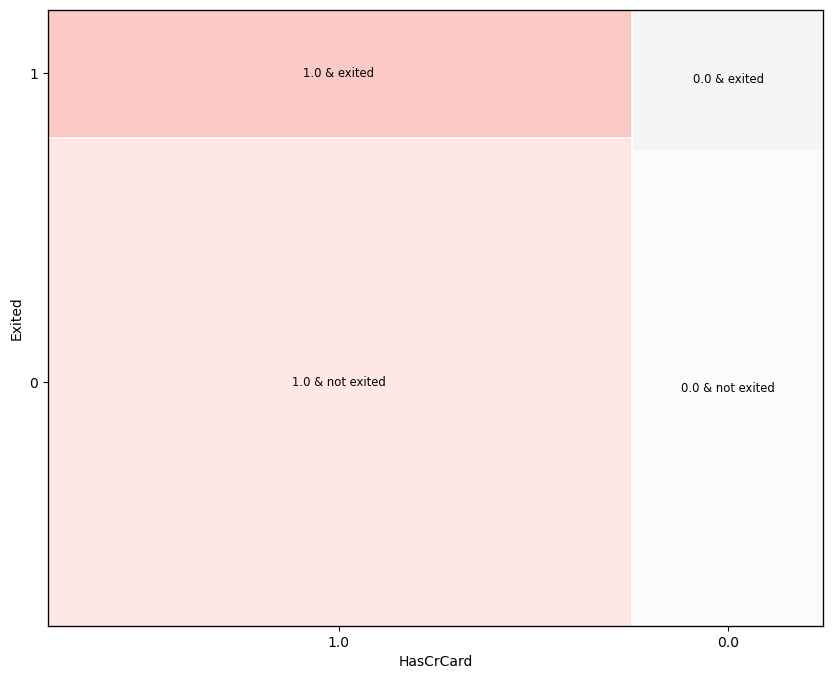

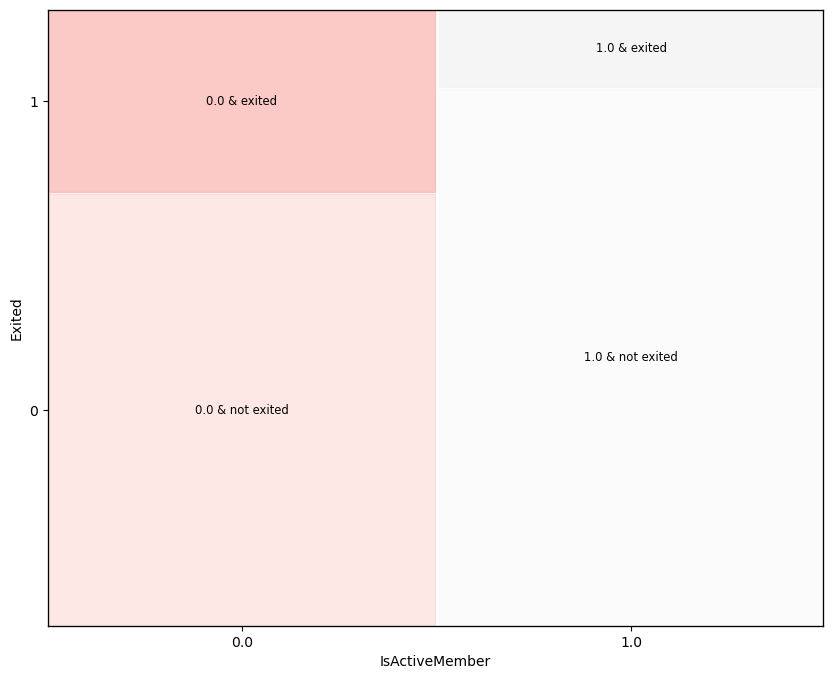

In [53]:
for column in cat_cols:
    create_mosaic_plot(train_df, column, 'Exited')

### 범주형 컬럼 관찰 결과
- 거주 국가별 가장 많은 이탈수는 가장 고객이 많은 프랑스이지만 비율로 봤을 때는 독일의 이탈률이 가장 큽니다.
- 성별 이탈 수에서는 여성의 이탈 비율이 높은 것으로 보입니다.
- 비활성 고객들의 이탈률이 높습니다.

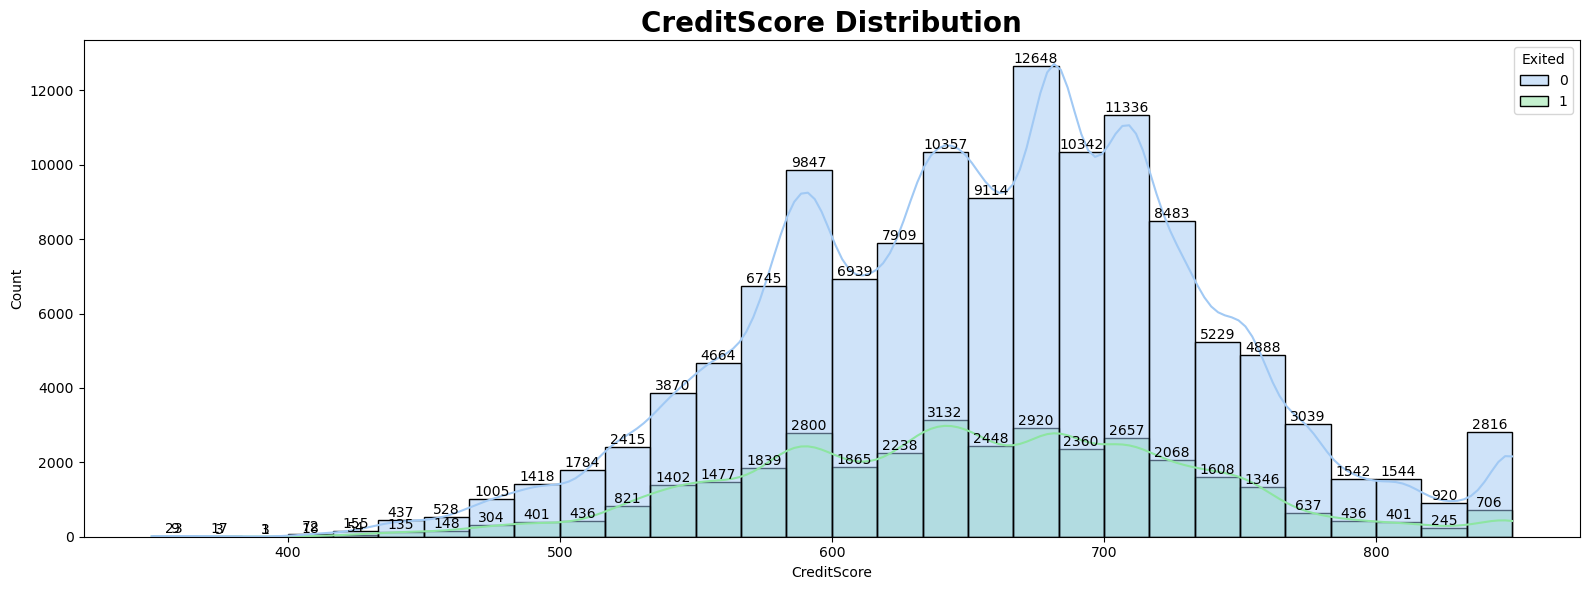

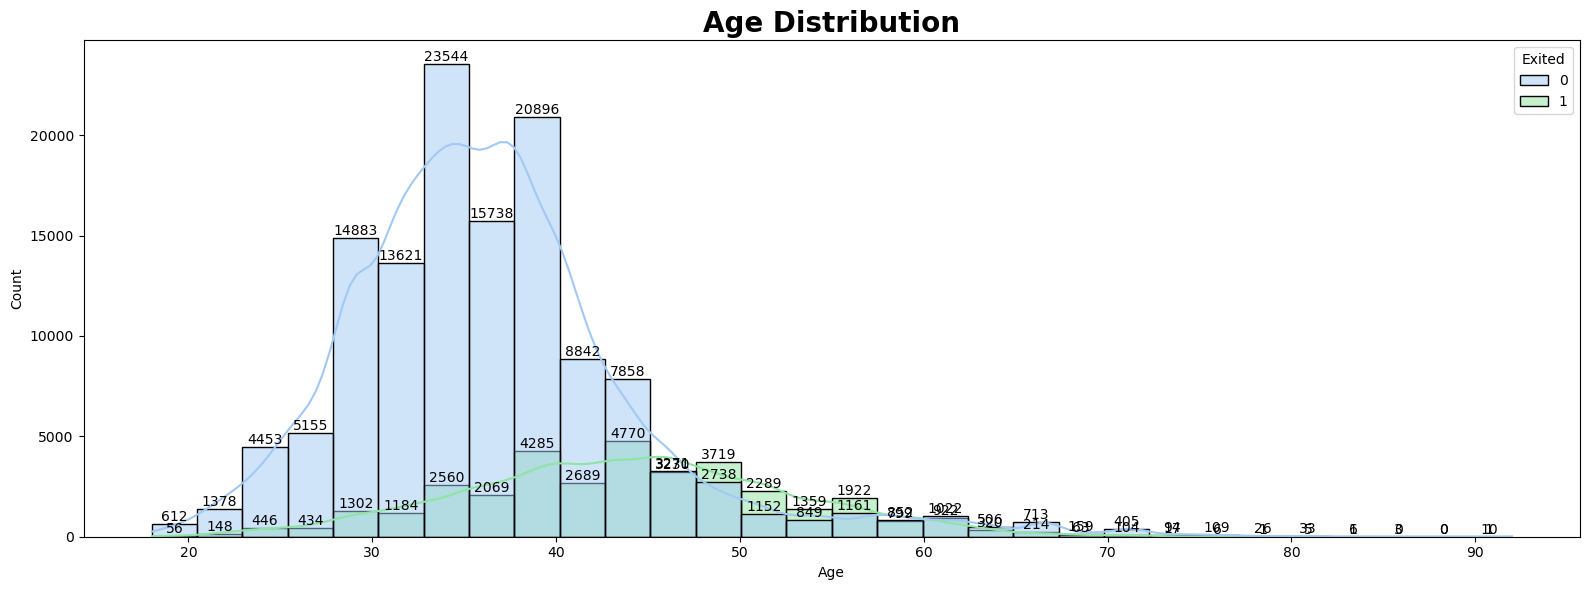

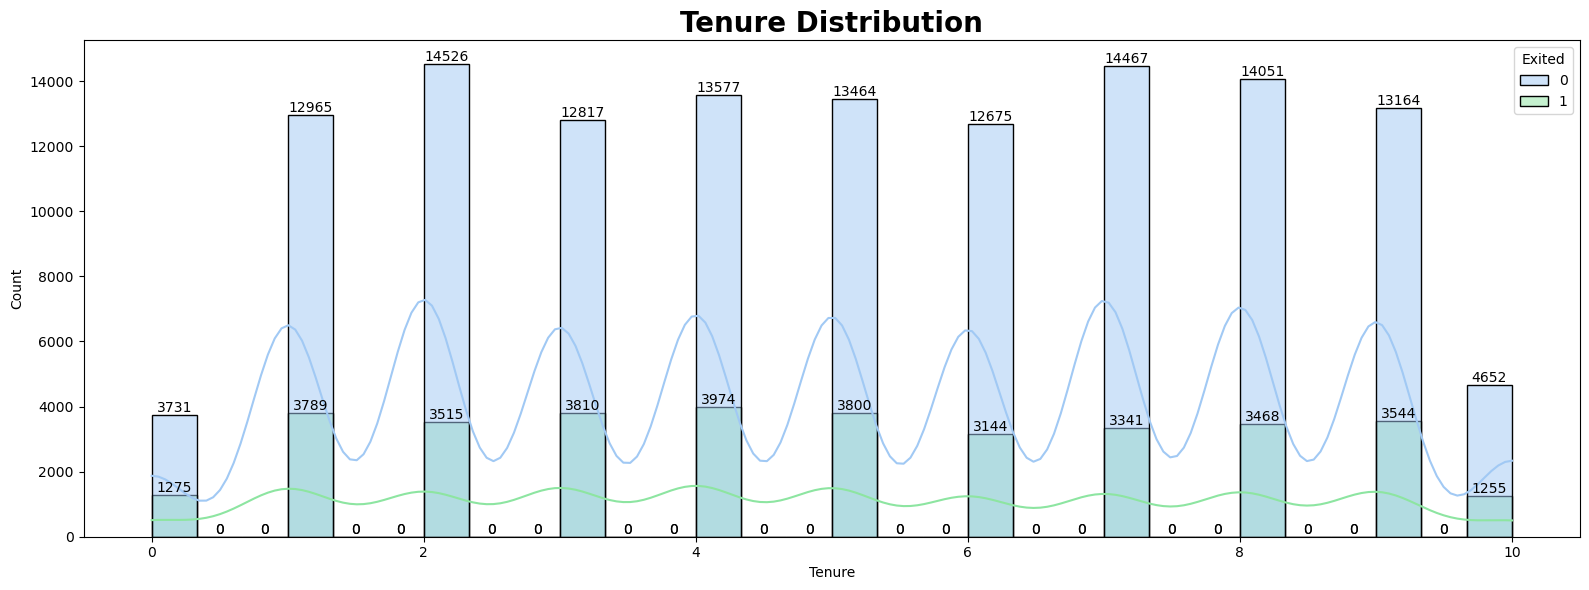

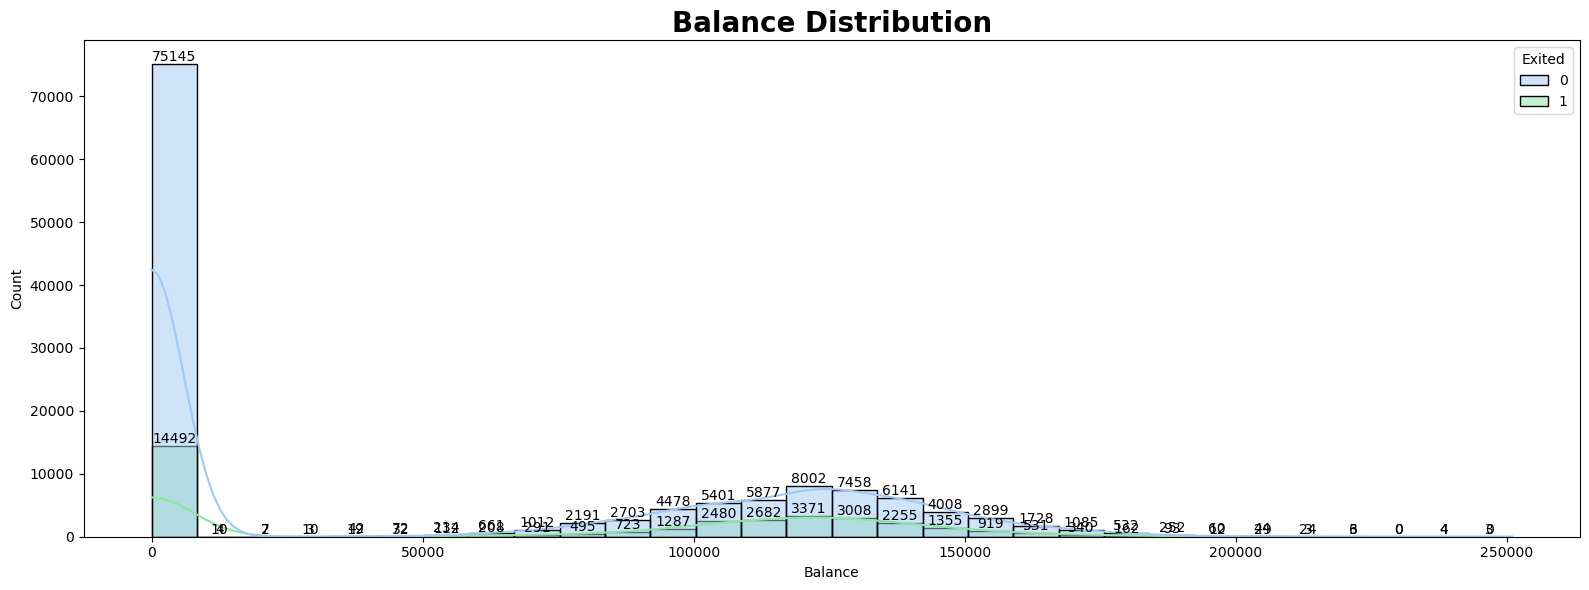

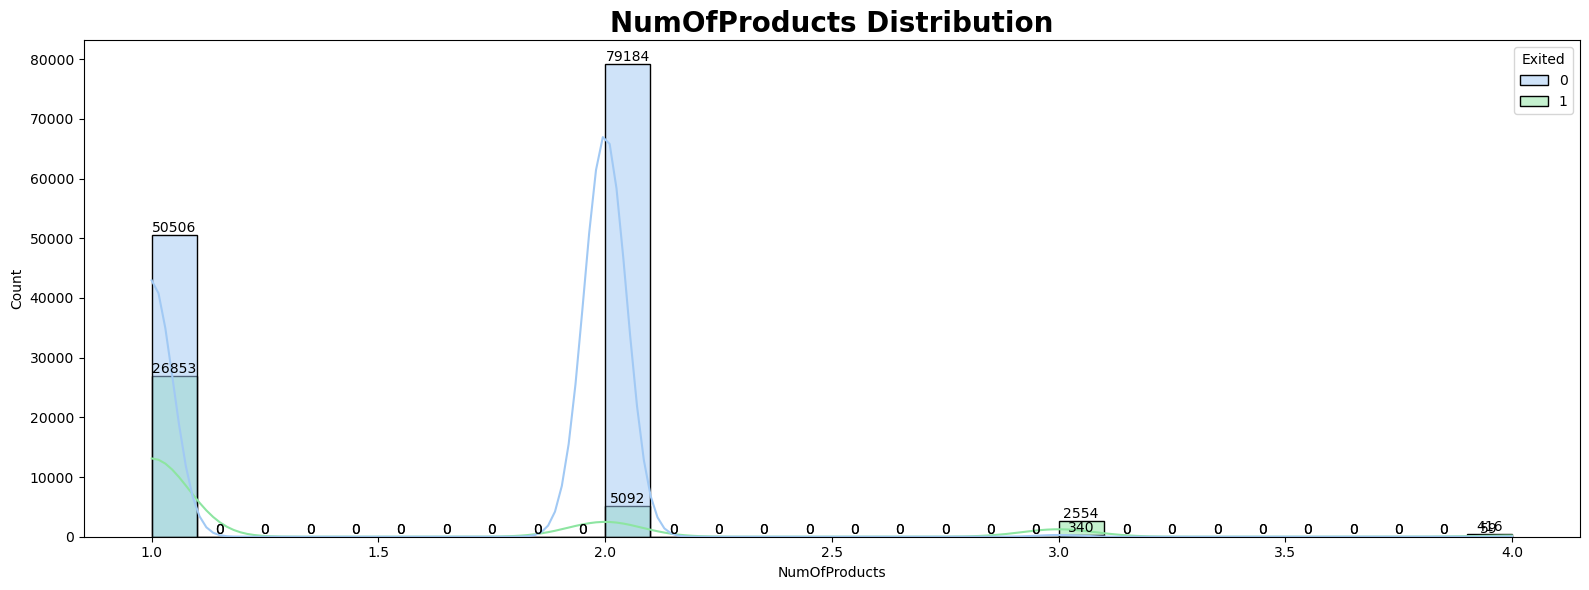

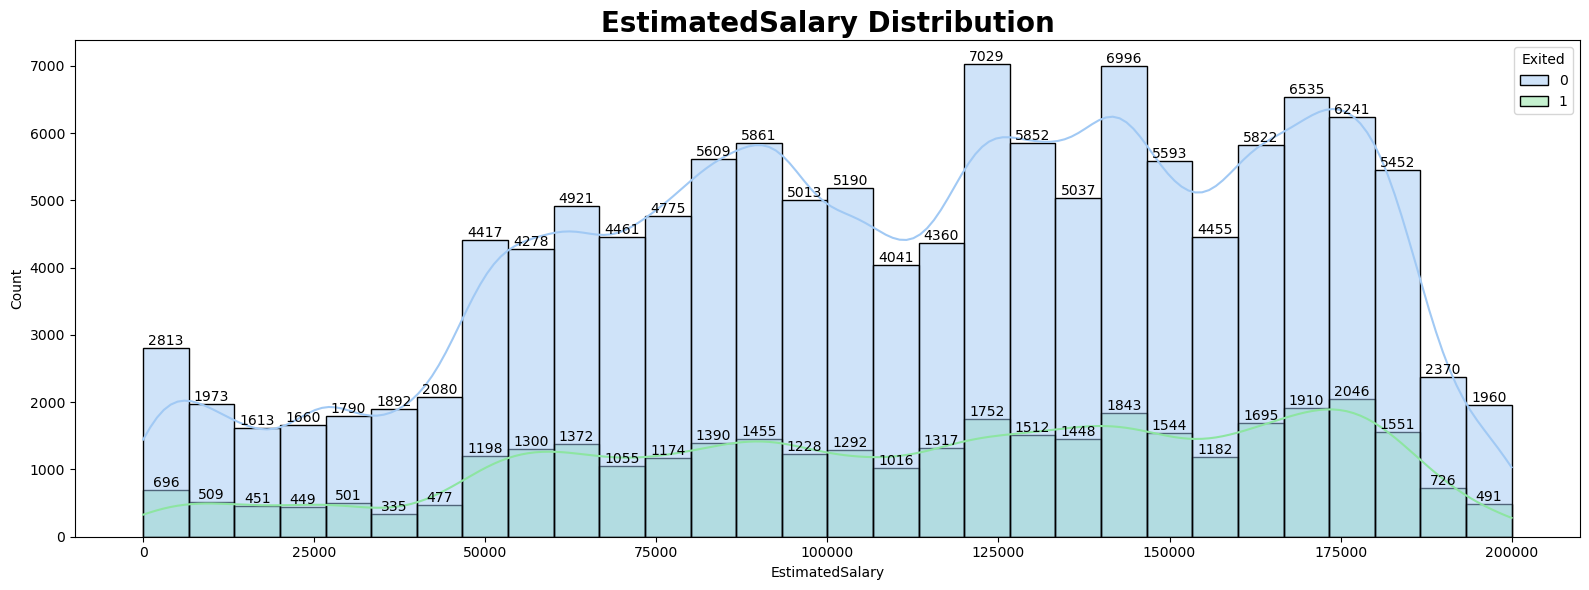

In [56]:
for column in num_cols:
    fig, ax = plt.subplots(figsize=(16, 6))
    fig = sns.histplot(x=column, hue="Exited", data=train_df,bins=30,kde=True, palette="pastel6", ax=ax)
    ax.bar_label(ax.containers[0], label_type='edge')
    ax.bar_label(ax.containers[1], label_type='edge')

    plt.title(f"{column} Distribution",weight='bold',fontsize=20)
    plt.tight_layout()
    plt.show()

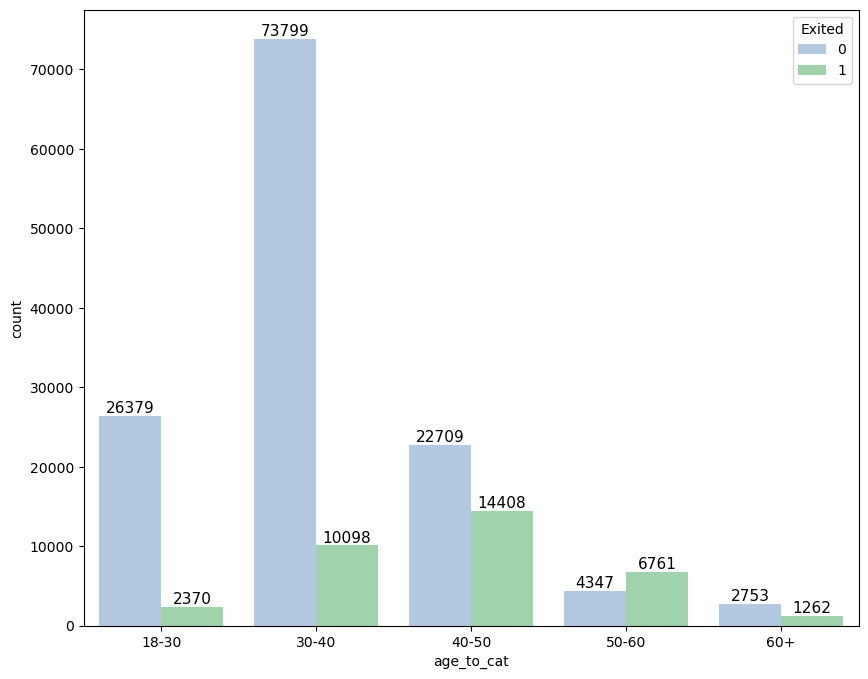

In [57]:
train_df['age_to_cat'] = pd.cut(train_df['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '30-40', '40-50', '50-60', '60+'])
draw_countplot(train_df, 'age_to_cat', 'Exited') 

### 수치형 컬럼 관찰 결과
- 나이

   - 전체 고객에서 30대가 가장 높은 비중을 차지합니다.
   - 50세를 전후한 나이에서 이탈 고객이 비이탈 고객보다 더 높은 숫자를 보입니다.
   - 이탈 고객은 40대가 가장 많은데, 연령대별 고객 중 이탈 고객의 비율은 50대가 가장 높습니다.
   - 18~40세까지의 고객에 비해 그 보다 연령대가 높은 고객들의 이탈 비율이 높습니다.

- 신용점수 분포는 600-700점 사이의 고객이 비교적 많습니다.

- 가입 기간으로는 1년 미만 고객의 분포가 가장 적고, 1년 이상 9년 이하 고객의 분포가 대부분이며, 9년이상 고객의 수가 가장 많습니다.

- 계좌 잔액

   - 25000 미만인 고객이 가장 많습니다.
   - 잔액이 50000 이상인 고객의 이탈률이 더 높습니다. 하지만, 이탈 고객 중 41%가 잔액이 50000 미만입니다.
   - 고객 보유 상품 수로는 2개를 가진 고객이 가장 많고, 다음으로는 1개를 가진 고객이 많습니다.

- 예상 급여로는 125000이상 175000미만 고객이 가장 많고, 50000이하인 고객이 비교적 적습니다.

- 이용 상품

   - 이용 상품이 많으면 은행의 충성 고객이라고 생각하기 쉬운데, 가입상품이 3, 4개인 고객들의 이탈비율이 더 높게 나타납니다.                                                                                                                                                               
      다수의 은행 상품을 이용하는 고객들은 재테크에 관심이 높다고 할 수 있는데, 이런 고객들이 상품 조건 등에 더 민감하게 반응해서 이탈했을 가능성이 있습니다.
  - 영업 전략으로는 이용 상품이 1개인 고객들을 2개로 만드는게 중요해보입니다.

> 분석 결과 :
- 연령대가 높고, 계좌 잔액이 큰 고객의 니즈를 충족시킬만한 상품이 부족하지 않을까 추측

### 수치형 컬럼 박스플랏

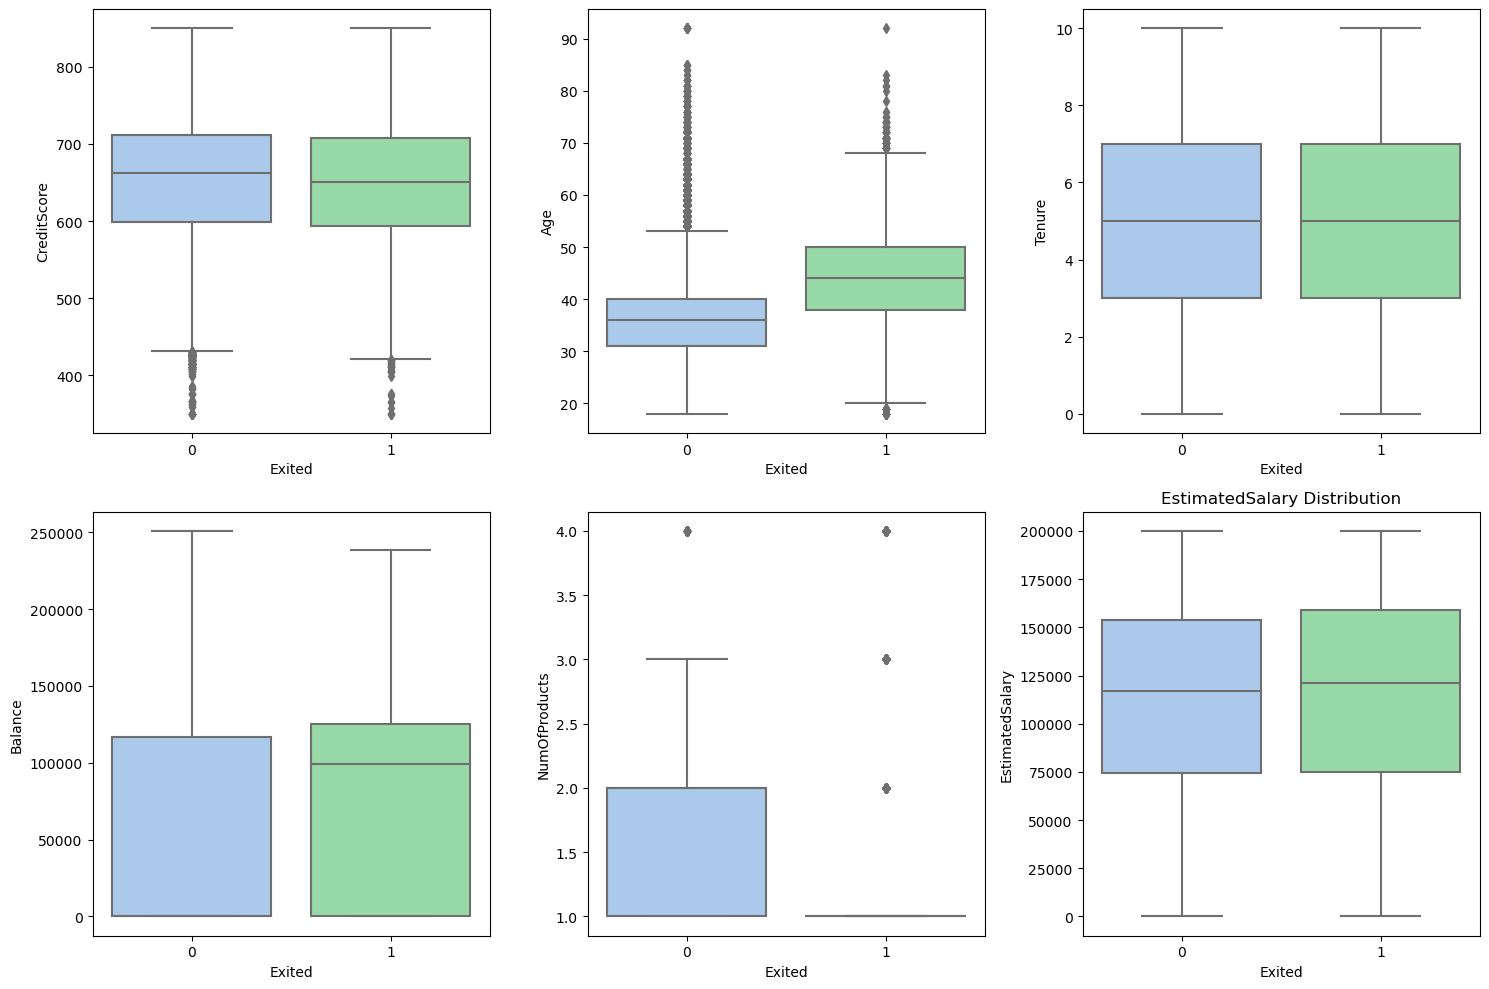

In [65]:
nrows = 2
ncols = 3
i = 0
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 10))
for row in range(nrows):
    for col in range(ncols):
        sns.boxplot(x="Exited", y=num_cols[i], data=train_df, palette="pastel6", ax=ax[row,col])
        plt.title(f"{column} Distribution")
        plt.tight_layout()
        i+=1

### 상관 계수 확인

#### 수치형 컬럼

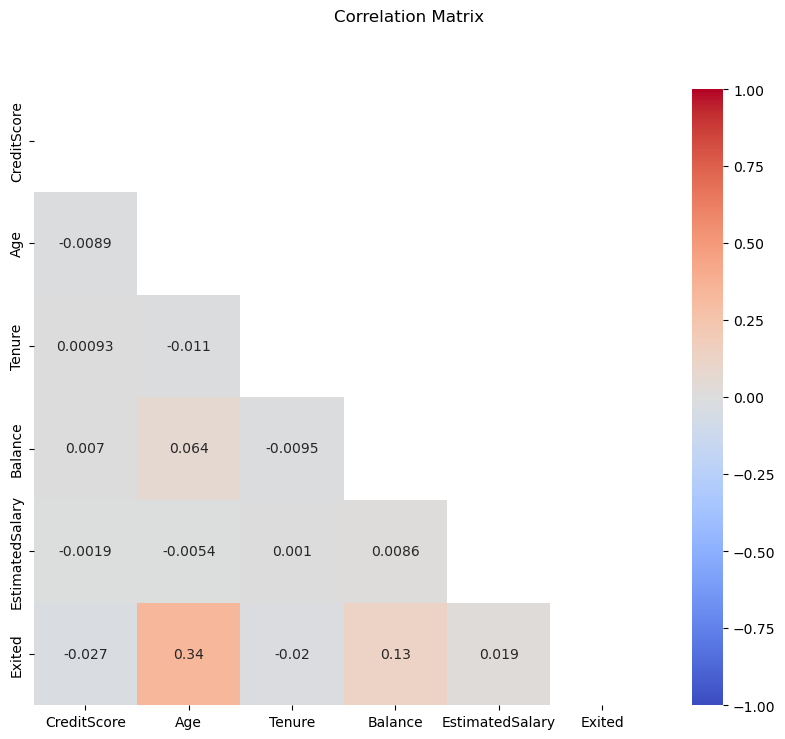

In [67]:
df_digit = train_df[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Exited']].copy()

corr_matrix=df_digit.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f,ax=plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.suptitle('Correlation Matrix')
plt.show()

- 나이, 잔고가 이탈률과 상관관계가 있어 보입니다.

#### 범주형 컬럼

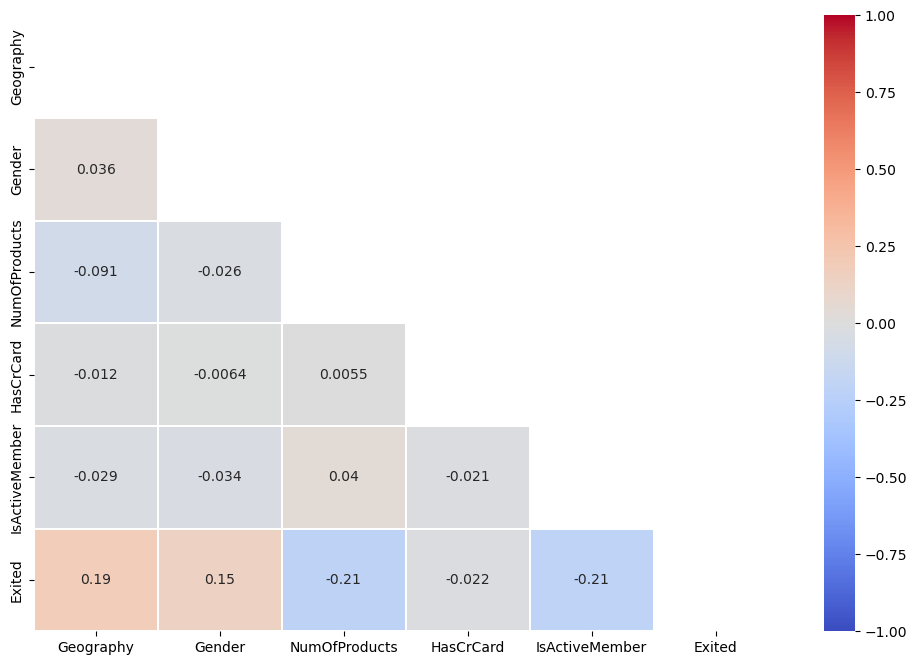

In [68]:
result_cat_digit = train_df[['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']].copy()
geo_plus_gen = train_df[['Geography','Gender']].copy()
geo_plus_gen

df_cat = geo_plus_gen.apply(lambda x: pd.factorize(x)[0])
df_cat_corr = pd.concat([df_cat, result_cat_digit],axis = 1).corr()

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df_cat_corr, dtype=bool))
ax = sns.heatmap(df_cat_corr, mask=mask, xticklabels=df_cat_corr.columns, yticklabels=df_cat_corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

-  거주국가, 성별, 가입상품수, 활성멤버여부가 이탈률과 상관관계가 있어 보입니다.

## 4. 모델링

### 데이터 나누기

In [70]:
train_df = train_df.drop(['CustomerId', 'age_to_cat'], axis = 1)
train_df_encoded = pd.get_dummies(train_df, columns=['Geography','Gender'])
train_df_encoded.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,0.0,2,1.0,0.0,181449.97,0,True,False,False,False,True
1,627,33.0,1,0.0,2,1.0,1.0,49503.50,0,True,False,False,False,True
2,678,40.0,10,0.0,2,1.0,0.0,184866.69,0,True,False,False,False,True


In [71]:
X = train_df_encoded.drop('Exited', axis = 1)
y = train_df_encoded['Exited']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((132003, 13), (33001, 13), (132003,), (33001,))

In [72]:
y_train.value_counts()

Exited
0    104112
1     27891
Name: count, dtype: int64

### 모델 성능 출력 함수

In [114]:
def get_clf_eval(y_test, pred, pred_proba):
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    re = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred_proba)
    
    # confusion = confusion_matrix(y_test, pred)
    
    # print("=> confusion matrix")
    # print(confusion)
    # print('===========')

    # print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc,pre))
    # print('Recall : {0:.4f}, F1: {1:.4f}, ROC_AUC: {2:.4f}'.format(re, f1, auc))
    return acc, pre, re, f1, auc

In [74]:
def print_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred, pred_proba)

    print("=> confusion matrix")
    print(confusion)
    print('===========')

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc,pre))
    print('Recall : {0:.4f}, F1: {1:.4f}, ROC_AUC: {2:.4f}'.format(re, f1, auc))

### 모델별 결과 정리 함수

In [101]:
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)
    return get_clf_eval(y_test, pred, pred_proba[:,1])

In [76]:
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
    tmp =[]

    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [77]:
def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))

    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label= model_names[model])

    plt.plot([0,1],[0,1], 'k--', label='random guess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

### class_weight로 불균형 데이터 처리

In [97]:
col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

lr = LogisticRegression(class_weight = 'balanced', random_state = 13, solver = 'liblinear')
dt = DecisionTreeClassifier(class_weight = 'balanced', random_state = 13, max_depth = 5)
rf = RandomForestClassifier(class_weight = 'balanced', random_state = 13, max_depth = 5, n_jobs = -1)
lgbm = LGBMClassifier(class_weight = 'balanced', random_state = 13, verbose = 0)
xgb = XGBClassifier(scale_pos_weight = scale_pos_weight, random_state = 13, max_depth = 5)
cat = CatBoostClassifier(scale_pos_weight=scale_pos_weight, random_state=13, max_depth = 5)

In [ ]:
lr.fit(X_train, y_train)
joblib.dump(lr, f'../model/lr.joblib')
dt.fit(X_train, y_train)
joblib.dump(dt, f'../model/dt.joblib')
rf.fit(X_train, y_train)
joblib.dump(rf, f'../model/rf.joblib')
lgbm.fit(X_train, y_train)
joblib.dump(lgbm, f'../model/lgbm.joblib')
xgb.fit(X_train, y_train)
joblib.dump(xgb, f'../model/xgb.joblib')
cat.fit(X_train, y_train)
joblib.dump(cat, f'../model/cat.joblib')

In [102]:
models = [lr, dt, rf, lgbm, xgb, cat]
result = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
result 

=> confusion matrix
[[19497  6480]
 [ 1784  5240]]
Accuracy : 0.7496, Precision : 0.4471
Recall : 0.7460, F1: 0.5591, ROC_AUC: 0.8152
=> confusion matrix
[[20807  5170]
 [ 1592  5432]]
Accuracy : 0.7951, Precision : 0.5124
Recall : 0.7733, F1: 0.6164, ROC_AUC: 0.8695
=> confusion matrix
[[20597  5380]
 [ 1487  5537]]
Accuracy : 0.7919, Precision : 0.5072
Recall : 0.7883, F1: 0.6172, ROC_AUC: 0.8732
=> confusion matrix
[[21389  4588]
 [ 1474  5550]]
Accuracy : 0.8163, Precision : 0.5474
Recall : 0.7901, F1: 0.6468, ROC_AUC: 0.8882
=> confusion matrix
[[21364  4613]
 [ 1495  5529]]
Accuracy : 0.8149, Precision : 0.5452
Recall : 0.7872, F1: 0.6442, ROC_AUC: 0.8865
Learning rate set to 0.082875
0:	learn: 0.6477045	total: 11.5ms	remaining: 11.5s
1:	learn: 0.6099702	total: 22ms	remaining: 11s
2:	learn: 0.5814354	total: 32ms	remaining: 10.6s
3:	learn: 0.5571594	total: 41.9ms	remaining: 10.4s
4:	learn: 0.5373757	total: 52.7ms	remaining: 10.5s
5:	learn: 0.5215960	total: 63.5ms	remaining: 10.5s


,Accuracy,Precision,Recall,F1,ROC_AUC
LogisticReg,0.749583,0.447099,0.746014,0.559112,0.815155
DecisionTree,0.795097,0.512356,0.773349,0.616362,0.869480
RandomForest,0.791915,0.507191,0.788297,0.617245,0.873203
LightGBM,0.816309,0.547445,0.790148,0.646778,0.888204
XGBoost,0.814915,0.545159,0.787158,0.644180,0.886456
CatBoost,0.814581,0.544463,0.788867,0.644265,0.887859


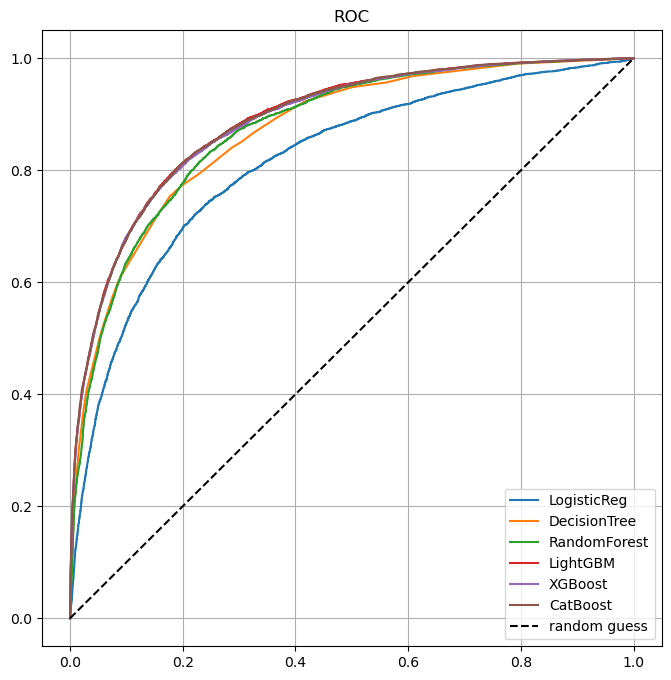

In [105]:
draw_roc_curve(models, model_names, X_test, y_test)

## class_weight로 불균형 처리 GridSearch

### 1. Decision Tree

In [115]:
params = {'max_depth': [3, 5, 7, 10]}

dt = DecisionTreeClassifier(class_weight = 'balanced', random_state = 13, max_depth = 5)

dt_gs = GridSearchCV(estimator=dt, param_grid=params, cv = 5,  scoring='roc_auc')
dt_gs.fit(X_train,y_train)
joblib.dump(dt_gs, f'../model/dt_gs.joblib')

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              max_depth=5, random_state=13),
             param_grid={'max_depth': [3, 5, 7, 10]}, scoring='roc_auc')

In [117]:
dt_gs.best_score_, dt_gs.best_params_

(0.8831439366329269, {'max_depth': 7})

In [118]:
dt_gs = dt_gs.best_estimator_
dt_pred = dt_gs.predict(X_test)
dt_proba = dt_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, dt_pred, dt_proba)

=> confusion matrix
[[21512  4465]
 [ 1589  5435]]
Accuracy : 0.8166, Precision : 0.5490
Recall : 0.7738, F1: 0.6423, ROC_AUC: 0.8831


### 2. Logsitic Regression GridSearch

In [119]:
params = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['saga', 'liblinear', 'lbfgs'],
              'max_iter': [100, 300, 500]}

lr = LogisticRegression(class_weight = 'balanced', random_state = 13, solver = 'liblinear')

lr_gs = GridSearchCV(estimator=lr, param_grid=params, cv = 3, scoring='roc_auc', n_jobs = -1)
lr_gs.fit(X_train,y_train)
joblib.dump(lr_gs, f'../model/lr_gs.joblib')

['../model/lr_gs.joblib']

In [120]:
lr_gs.best_score_, lr_gs.best_params_

(0.8187015606132144,
 {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'})

In [121]:
lr_gs = lr_gs.best_estimator_
lr_pred = lr_gs.predict(X_test)
lr_proba = lr_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, lr_pred, lr_proba)

=> confusion matrix
[[19691  6286]
 [ 1827  5197]]
Accuracy : 0.7542, Precision : 0.4526
Recall : 0.7399, F1: 0.5616, ROC_AUC: 0.8187


### 3. Random Forest GridSearch

In [122]:
params = {
	'n_estimators':[50, 100, 200],
	'max_depth':[3, 5, 10],
	'min_samples_leaf':[8, 12, 18],
	'min_samples_split':[8, 12, 18]
}

rf = RandomForestClassifier(class_weight = 'balanced', random_state = 13, max_depth = 3, n_jobs = -1)
rf_gs = GridSearchCV(estimator = rf, cv = 3, param_grid = params, n_jobs = -1, scoring='roc_auc')
rf_gs.fit(X_train, y_train)
joblib.dump(rf_gs, f'../model/rf_gs.joblib')

['../model/rf_gs.joblib']

In [123]:
rf_gs.best_score_, rf_gs.best_params_

(0.8858694156601098,
 {'max_depth': 10,
  'min_samples_leaf': 8,
  'min_samples_split': 8,
  'n_estimators': 200})

In [124]:
rf_gs = rf_gs.best_estimator_
rf_pred = rf_gs.predict(X_test)
rf_proba = rf_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, rf_pred, rf_proba)

=> confusion matrix
[[21379  4598]
 [ 1513  5511]]
Accuracy : 0.8148, Precision : 0.5452
Recall : 0.7846, F1: 0.6433, ROC_AUC: 0.8851


### 4. LightGBM GridSearch

In [ ]:
params = {
    'boosting_type': ['gbdt'],
    'n_estimators': [100, 300, 1000],
    'max_depth' : [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 0.9, 1.0],
}

lgbm = LGBMClassifier(class_weight = 'balanced', random_state = 13, verbose = 0)

lgbm_gs = GridSearchCV(estimator = lgbm, param_grid = params, cv = 3, scoring='roc_auc')
early_stopping_rounds = 10
eval_set =  [(X_test, y_test)]
lgbm_gs = lgbm_gs.fit(X_train, y_train, eval_set = [(X_test, y_test)], callbacks=[early_stopping(10, verbose=0)])
joblib.dump(lgbm_gs, f'../model/lgbm_gs.joblib')

In [107]:
lgbm_gs.best_score_, lgbm_gs.best_params_

(0.889245889666582,
 {'boosting_type': 'gbdt',
  'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 1000,
  'num_leaves': 31,
  'subsample': 0.8})

In [108]:
lgbm_gs = lgbm_gs.best_estimator_
lgbm_pred = lgbm_gs.predict(X_test)
lgbm_pred_proba = lgbm_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, lgbm_pred, lgbm_pred_proba)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
=> confusion matrix
[[21358  4619]
 [ 1463  5561]]
Accuracy : 0.8157, Precision : 0.5463
Recall : 0.7917, F1: 0.6465, ROC_AUC: 0.8884
=> confusion matrix
[[21358  4619]
 [ 1463  5561]]
Accuracy : 0.8157, Precision : 0.5463
Recall : 0.7917, F1: 0.6465, ROC_AUC: 0.8884


### 5. XGBoost GridSearch

In [109]:
params = {
    'n_estimators': [100, 300, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'subsample': [0.8]
}
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb = XGBClassifier(scale_pos_weight = scale_pos_weight, random_state = 13, max_depth = 3, verbose = 0)

xgb_gs = GridSearchCV(estimator = xgb, param_grid = params, cv = 3, verbose = 0, n_jobs = -1, scoring='roc_auc')
xgb_gs.fit(X_train, y_train)
joblib.dump(xgb_gs, f'../model/xgb_gs.joblib')

['../model/xgb_gs.joblib']

In [110]:
xgb_gs.best_score_, xgb_gs.best_params_

(0.8895357217962986,
 {'learning_rate': 0.01,
  'max_depth': 5,
  'n_estimators': 1000,
  'subsample': 0.8})

In [111]:
xgb_gs = xgb_gs.best_estimator_
xgb_pred = xgb_gs.predict(X_test)
xgb_pred_proba = xgb_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, xgb_pred, xgb_pred_proba)

=> confusion matrix
[[21286  4691]
 [ 1435  5589]]
Accuracy : 0.8144, Precision : 0.5437
Recall : 0.7957, F1: 0.6460, ROC_AUC: 0.8886
=> confusion matrix
[[21286  4691]
 [ 1435  5589]]
Accuracy : 0.8144, Precision : 0.5437
Recall : 0.7957, F1: 0.6460, ROC_AUC: 0.8886


### 6. CatBoost GridSearch

In [ ]:
params = {
    'max_depth': [3, 7, 10]
}
    
cat = CatBoostClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)
cat_gs = GridSearchCV(cat, param_grid=params, cv=3, verbose=0, scoring='roc_auc', n_jobs=-1)
cat_gs.fit(X_train, y_train)
joblib.dump(cat_gs, f'../model/cat_gs.joblib')

In [113]:
cat_best = cat_gs.best_estimator_
cat_pred = cat_best.predict(X_test)
cat_pred_proba = cat_best.predict_proba(X_test)[:,1]

print_clf_eval(y_test, cat_pred, cat_pred_proba)

=> confusion matrix
[[21213  4764]
 [ 1422  5602]]
Accuracy : 0.8126, Precision : 0.5404
Recall : 0.7976, F1: 0.6443, ROC_AUC: 0.8889
=> confusion matrix
[[21213  4764]
 [ 1422  5602]]
Accuracy : 0.8126, Precision : 0.5404
Recall : 0.7976, F1: 0.6443, ROC_AUC: 0.8889


In [125]:
tmp = []
col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']

tmp.append(get_clf_eval(y_test, lr_pred, lr_proba))
tmp.append(get_clf_eval(y_test, dt_pred, dt_proba))
tmp.append(get_clf_eval(y_test, rf_pred, rf_proba))
tmp.append(get_clf_eval(y_test, lgbm_pred, lgbm_pred_proba))
tmp.append(get_clf_eval(y_test, xgb_pred, xgb_pred_proba))
tmp.append(get_clf_eval(y_test, cat_pred, cat_pred_proba))


result = pd.DataFrame(tmp, columns=col_names, index=model_names)
result

,Accuracy,Precision,Recall,F1,ROC_AUC
LogisticReg,0.754159,0.452582,0.739892,0.561625,0.818693
DecisionTree,0.816551,0.548990,0.773776,0.642283,0.883142
RandomForest,0.814824,0.545158,0.784596,0.643320,0.885082
LightGBM,0.815703,0.546267,0.791714,0.646478,0.888351
XGBoost,0.814369,0.543677,0.795700,0.645978,0.888560
CatBoost,0.812551,0.540421,0.797551,0.644278,0.888941


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


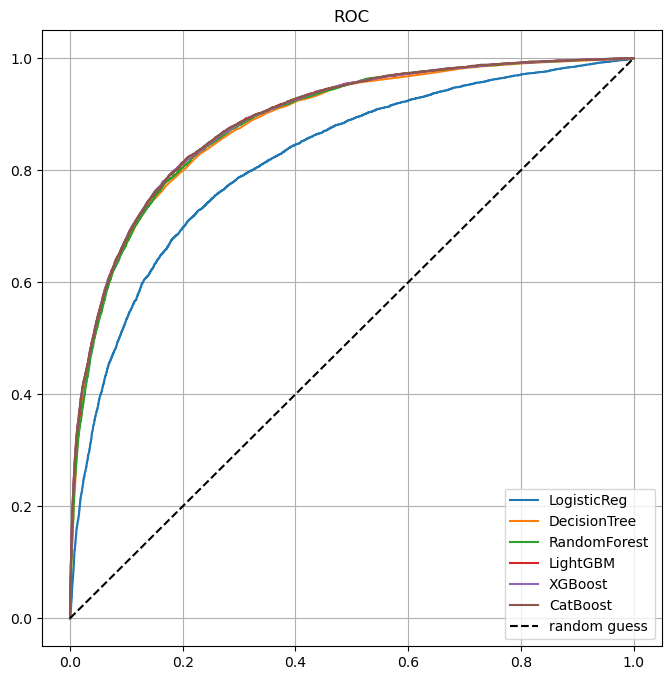

In [154]:
models = [lr_gs, dt_gs, rf_gs, lgbm_gs, xgb_gs, cat_best]
draw_roc_curve(models, model_names, X_test, y_test)

### 모델의 특성 중요도 확인

####  xgb

In [126]:
def get_feature_importance(model, X_train):
    fi = pd.DataFrame(list(zip(X_train.columns, model)), 
                        columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
    return fi

In [127]:
fi = get_feature_importance(xgb_gs.feature_importances_, X_train)
fi

,Feature,Importance
4,NumOfProducts,0.402654
1,Age,0.226216
6,IsActiveMember,0.136057
9,Geography_Germany,0.071775
11,Gender_Female,0.060565
3,Balance,0.044408
5,HasCrCard,0.017522
0,CreditScore,0.009273
7,EstimatedSalary,0.008589
2,Tenure,0.008119


 - 모델 특성 중요도
    - xgboost : 가입 상품 수, 나이, 활성멤버, 거주지역(독일), 여성, 잔고

####  CatBoost

In [129]:
fi = get_feature_importance(cat_best.feature_importances_, X_train)
fi

,Feature,Importance
4,NumOfProducts,44.772834
1,Age,26.567845
6,IsActiveMember,8.489923
3,Balance,7.101267
9,Geography_Germany,5.252117
0,CreditScore,1.996569
11,Gender_Female,1.847781
7,EstimatedSalary,1.832567
12,Gender_Male,0.947807
2,Tenure,0.646447


 - 모델 특성 중요도
    - catoost : 가입 상품 수, 나이, 활성멤버, 잔고, 거주지역(독일)

## 5. Original 데이터로 Test

In [130]:
origin_df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [131]:
origin_df = origin_df.drop(['RowNumber', 'Surname'], axis=1)
origin_df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,15647311,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,15619304,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,15701354,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,15737888,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [132]:
origin_df.duplicated().sum()

2

In [134]:
origin_df.drop_duplicates(inplace = True)
origin_df.dropna(inplace=True)
origin_df.head(5)

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,15647311,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,15619304,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,15701354,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,15574012,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1


In [135]:
real = origin_df['Exited']
origin_df = origin_df.drop(['CustomerId', 'Exited'], axis=1)
origin_df_encoded = pd.get_dummies(origin_df, columns=['Geography','Gender'])
origin_df_encoded.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42.0,2,0.00,1,1.0,1.0,101348.88,True,False,False,True,False
1,608,41.0,1,83807.86,1,0.0,1.0,112542.58,False,False,True,True,False
2,502,42.0,8,159660.80,3,1.0,0.0,113931.57,True,False,False,True,False


In [136]:
xgb_pred = xgb_gs.predict(origin_df_encoded)
xgb_pred_proba = xgb_gs.predict_proba(origin_df_encoded)[:,1]
print_clf_eval(real, xgb_pred, xgb_pred_proba)

=> confusion matrix
[[6265 1694]
 [ 449 1588]]
Accuracy : 0.7856, Precision : 0.4839
Recall : 0.7796, F1: 0.5971, ROC_AUC: 0.8692


#### xgboost 예측 결과
- 테스트 데이터에서 성능이 조금 하락하였고 예측 결과를 보자면
- 전체  9996명 중 0 =  7959,  1 = 2037 
- 실제 이탈하지 않은 7959명 중에 6265명을 0으로 잘 예측, 1694명은 1로 잘못 예측
- 실제 이탈한 2037명 중에 1588명을 1로 잘 예측, 449명은 0으로 잘못 예측

In [137]:
cat_pred = cat_best.predict(origin_df_encoded)
cat_pred_proba = cat_best.predict_proba(origin_df_encoded)[:,1]

print_clf_eval(real, cat_pred, cat_pred_proba)

=> confusion matrix
[[6218 1741]
 [ 434 1603]]
Accuracy : 0.7824, Precision : 0.4794
Recall : 0.7869, F1: 0.5958, ROC_AUC: 0.8702


#### catboost 예측 결과
- xgboost 모델과 같이 테스트 데이터에서 성능이 조금 하락하였고 예측 결과는
- 실제 이탈하지 않은 7959명 중에 6218명을 0으로 잘 예측, 1741명은 1로 잘못 예측
- 실제 이탈한 2037명 중에 1603명을 1로 잘 예측, 434명은 0으로 잘못 예측

## 테스트 결과 분석
### catboost로 분석

In [138]:
origin_df['Predict'] = cat_pred
origin_df.head(10)
result = origin_df
result['Real'] = real
result

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Predict,Real
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1,1
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0,0
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0,0
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,0,1


In [139]:
result.loc[result['Predict'] != result['Real']]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Predict,Real
18,587,Spain,Male,45.25,6,0.00,1,0.0,0.0,158684.81,1,0
24,846,France,Female,38.00,5,0.00,1,1.0,1.0,187616.16,1,0
28,574,Germany,Female,43.00,3,141349.43,1,1.0,1.0,100187.43,1,0
32,553,Germany,Male,41.00,9,110112.54,2,0.0,0.0,81898.81,1,0
40,472,Spain,Male,40.00,4,0.00,1,1.0,0.0,70154.22,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9969,609,France,Male,41.00,6,0.00,1,0.0,1.0,112585.19,1,0
9979,677,France,Female,58.00,1,90022.85,1,0.0,1.0,2988.28,1,0
9983,613,France,Male,40.00,4,0.00,1,0.0,0.0,151325.24,1,0
9990,714,Germany,Male,33.00,3,35016.60,1,1.0,0.0,53667.08,1,0


### 이탈 지표 분석

In [140]:
def plot_target(df: pd.DataFrame, col: str, title: str, pie_colors:list) -> None:
    i = 0
    for co in col:
        tie = ['Predict', 'Real']
        fig, ax = plt.subplots(1,2,figsize=(15, 6), width_ratios=[2,1])

        textprops={'fontsize': 12, 'weight': 'bold',"color": "black"}
        ax[0].pie(df[co].value_counts().to_list(),
                colors=pie_colors,
                labels=df[co].value_counts().index.to_list(),
                autopct='%1.f%%', 
                explode=([.05]*df[co].nunique()),
                pctdistance=0.5,
                wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
                textprops=textprops)

        sns.countplot(x = co, data=df, palette = "pastel6", order=df[co].value_counts().to_dict().keys())
        for p, count in enumerate(df[co].value_counts()):
            ax[1].text(p-0.11, count+np.sqrt(count)+1000, count, color='black', fontsize=13)
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        plt.yticks([])
        plt.box(False)
        fig.suptitle(x=0.56, t=f'► {tie[i]} {title} Distribution ◄', fontsize=18, fontweight='bold')
        plt.tight_layout()
        plt.show()
        i+=1

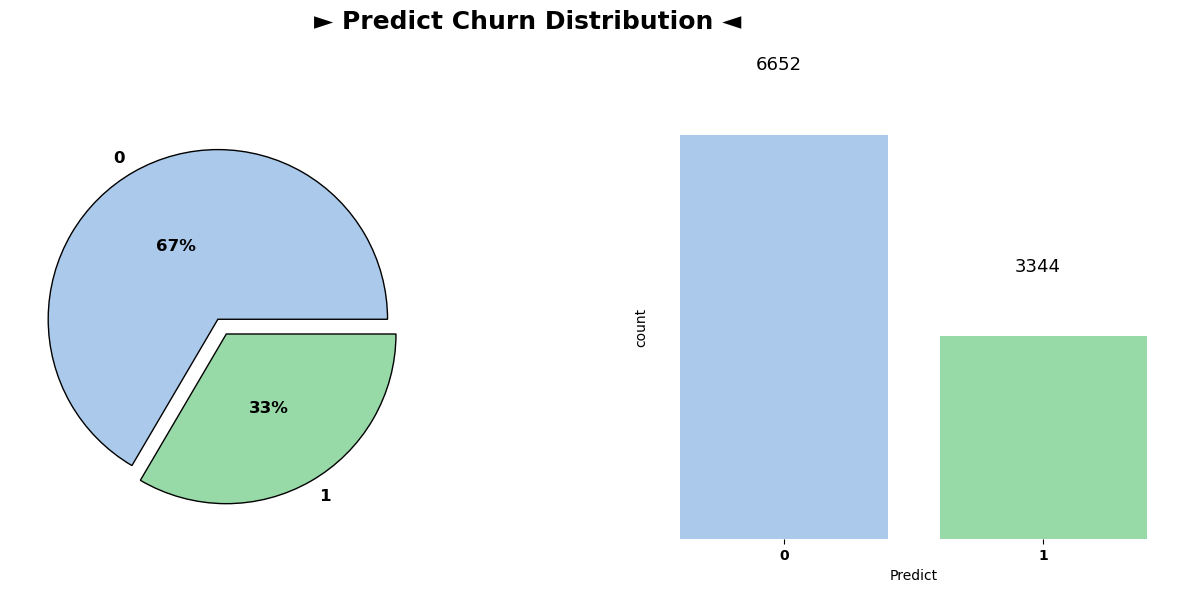

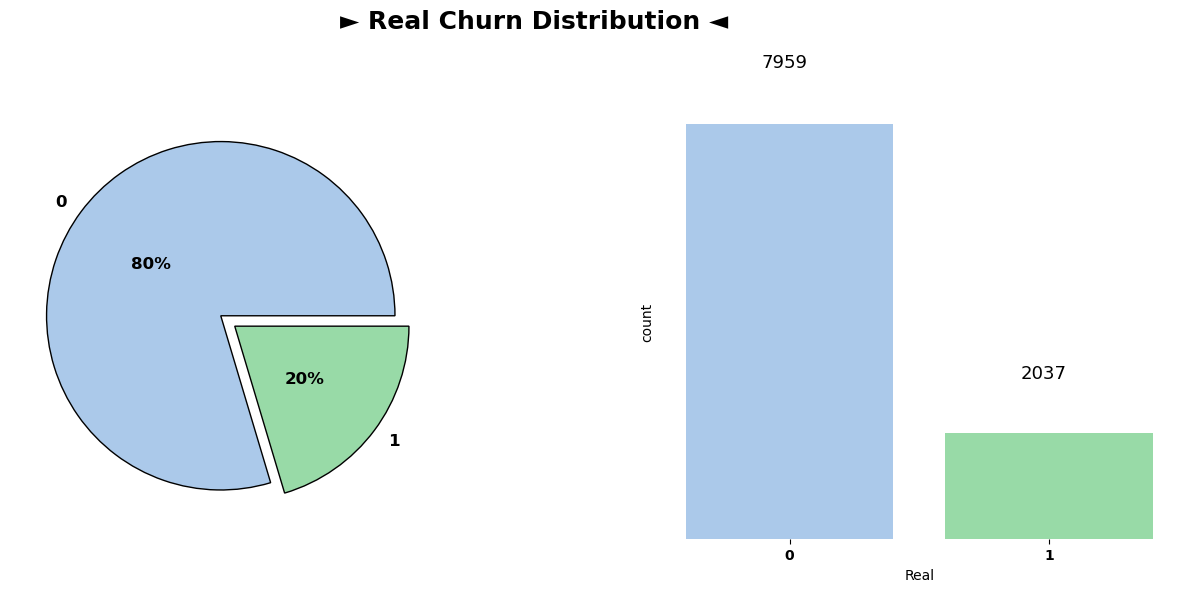

In [141]:
plot_target(result, 
            col=["Predict", "Real"], 
            title="Churn", 
            pie_colors=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])

- 실제 이탈 지표보다 모델이 예측한 이탈 지표에서 이탈했다고 예측한 사람이 더 많게 나온 것을 볼 수 있다.
- 아무래도 비교적 percision의 성능이 낮고 recall의 성능이 높다보니 1을 정확하게 예측하기보다는 최대한 많은 1을 예측하려고 했기 때문에 1의 지표가 더 많아진 것으로 생각된다.

In [47]:
# 범주형/수치형 컬럼 구분
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

### 범주형 변수 이탈 분석

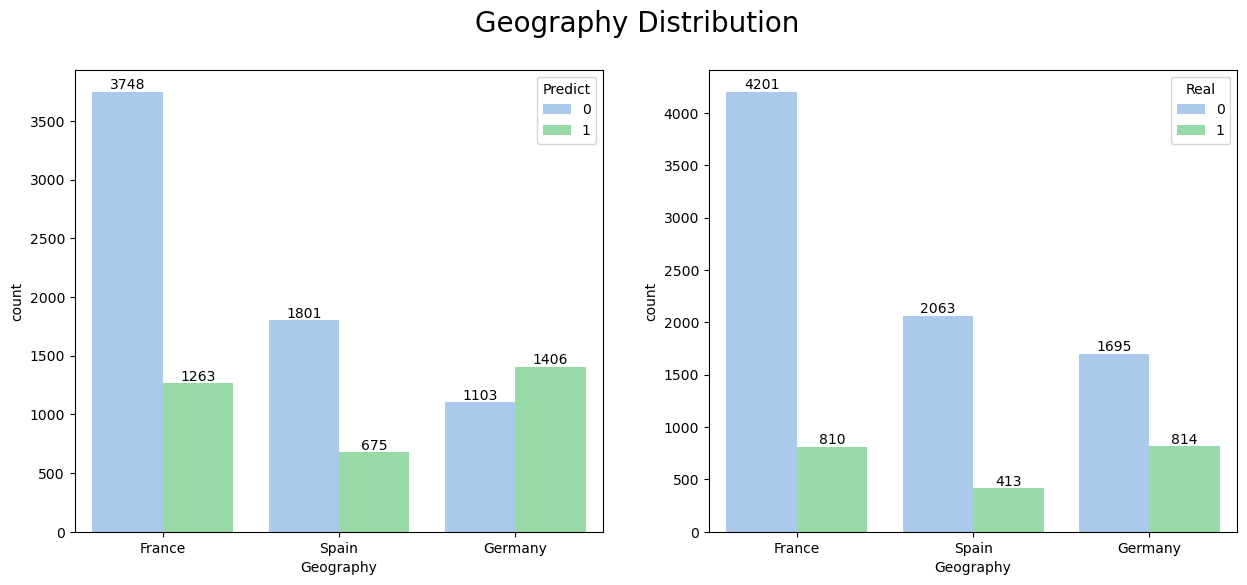

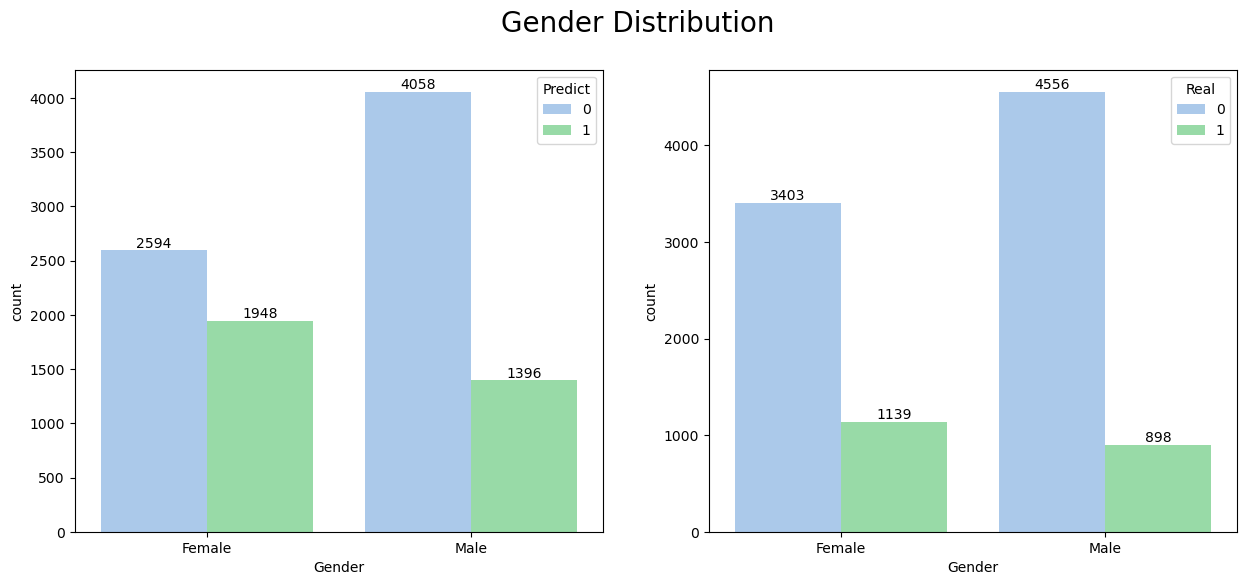

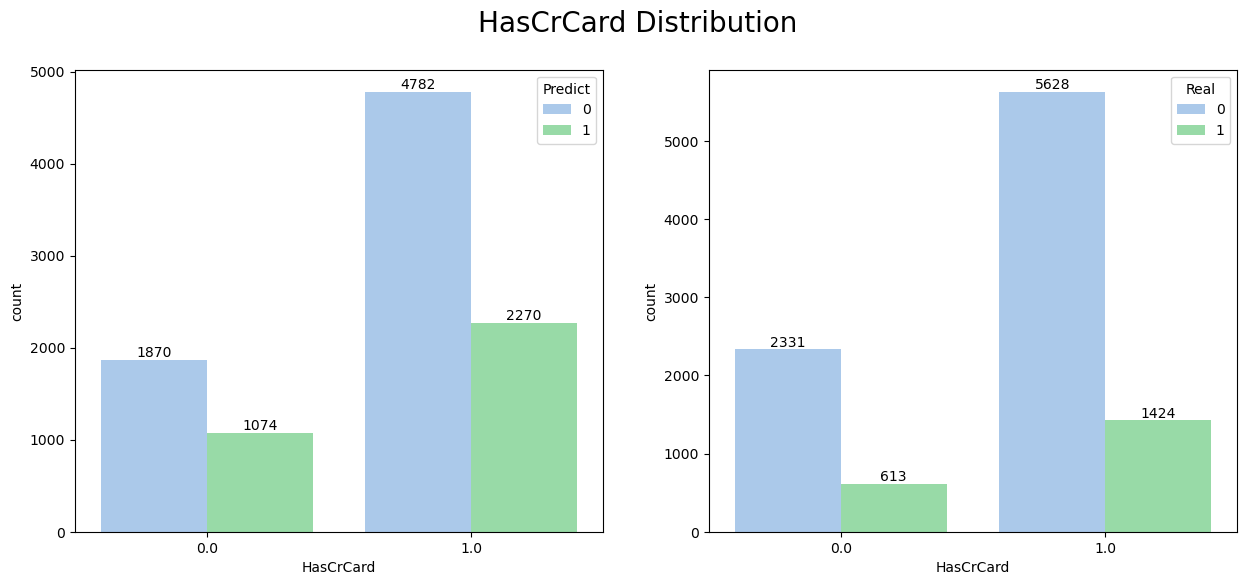

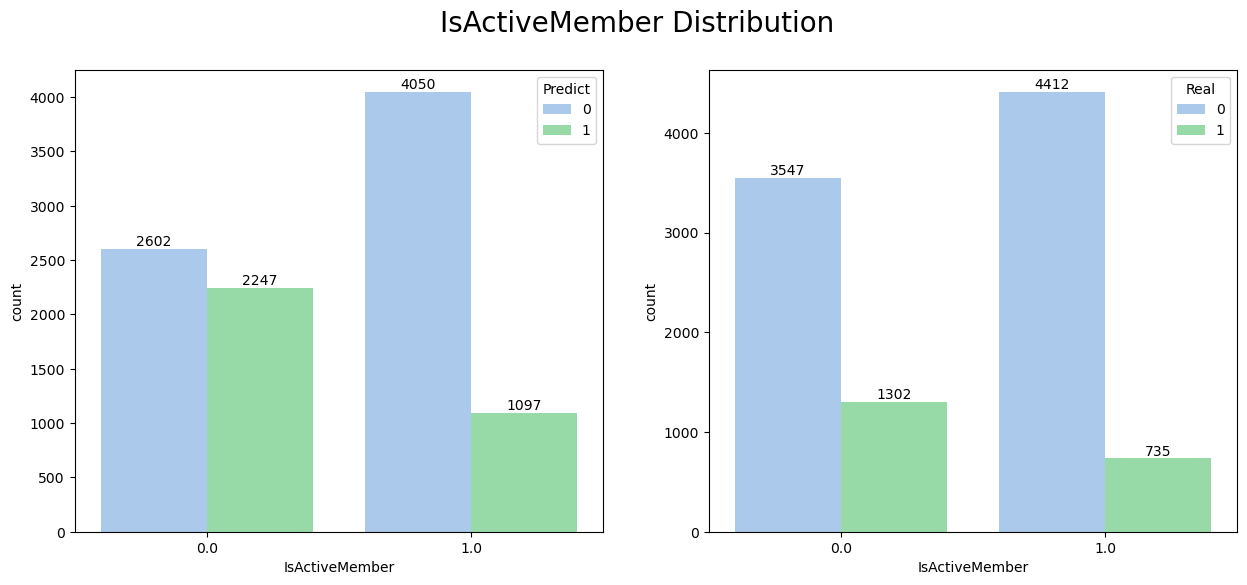

In [142]:
for column in cat_cols:
    hues = ["Predict", "Real"]
    i = 0
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), width_ratios=[1, 1])

    for ax in axes:
        sns.countplot(hue=hues[i], x=column, data=result, palette="pastel6", ax=ax)
        ax.bar_label(ax.containers[0])
        ax.bar_label(ax.containers[1])
        i+=1
    
    plt.suptitle(f'{column} Distribution', fontsize=20)
    plt.show()

- 실제 이탈 분포에 비례하게 예측값이 이탈 분포를 보이고 있고, 예측 모델의 특성 중요도가 높게 나온 거주지역(독일), 활성멤버, 여성에서의 이탈 비율이 급격히 높아진 것을 볼 수 있다.


In [49]:
def create_mosaic_plot(df, col1, col2):
    col1_values = df[col1].unique()
    col2_values = df[col2].unique()

    color_palette = plt.cm.get_cmap('Pastel1', len(col1_values))
    colors = {str(val): color_palette(i) for i, val in enumerate(col1_values)}
    
    alphas = np.linspace(0.3, 0.7, len(col2_values))
    alpha_dict = {str(val): alpha for val, alpha in zip(col2_values, alphas)}
    
    def props(key):
        color = colors.get(str(key[0]), (0, 0, 0))
        alpha = alpha_dict.get(str(key[1]), 1)
        return {'color': color[:3] + (alpha,)}

    def labels(key):
        lab1 = {str(val): str(val) for val in col1_values}
        lab2 = {str(val): str(val) for val in col2_values} if col2 != 'Exited' else {'1': 'exited', '0': 'not exited'}

        label = f'{lab1.get(key[0], "unknown")} & {lab2.get(key[1], "unknown")}'
        return label

    fig, ax = plt.subplots(figsize=(16, 8))
    mosaic(df, [col1, col2], properties=props, labelizer=labels, ax=ax)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.grid(False)
    plt.show()

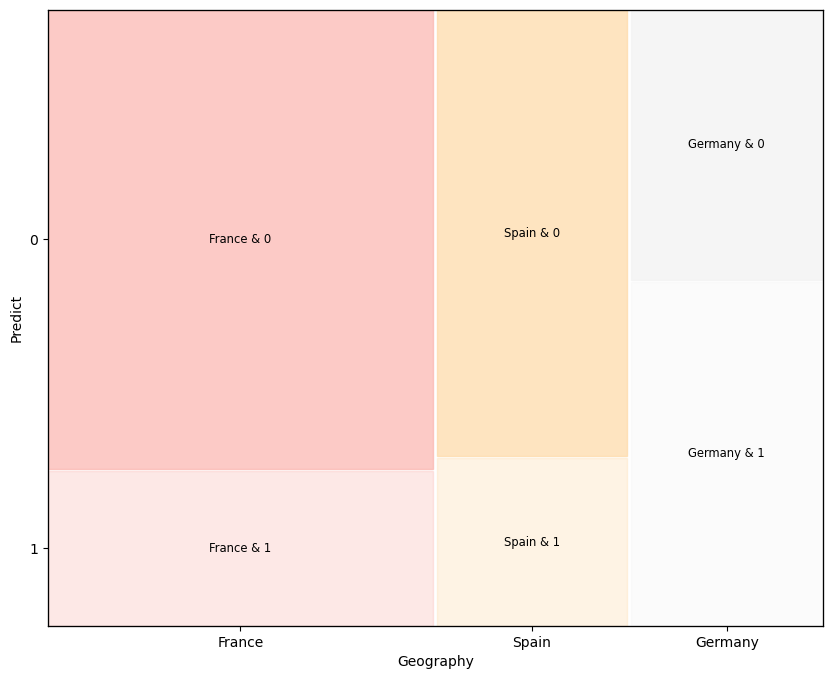

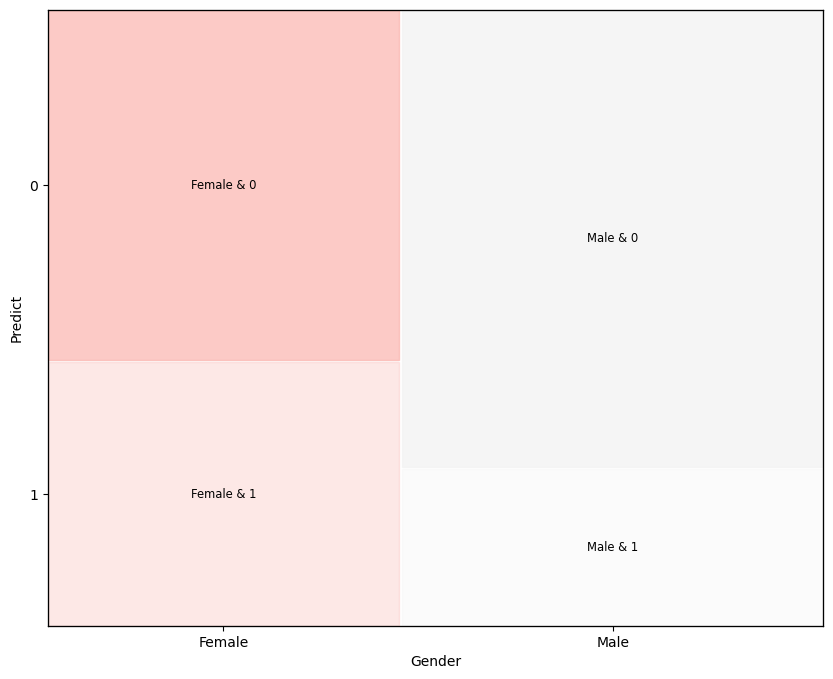

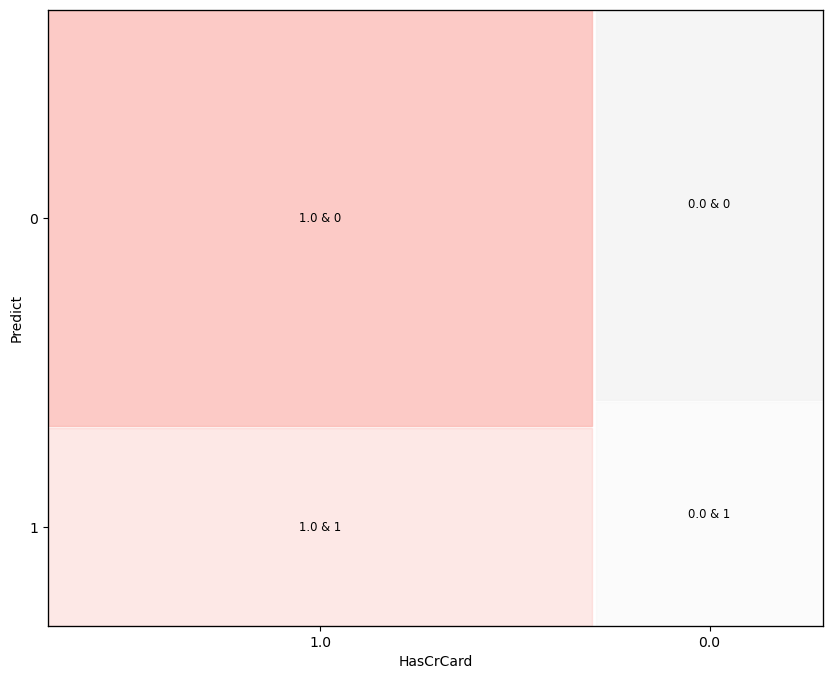

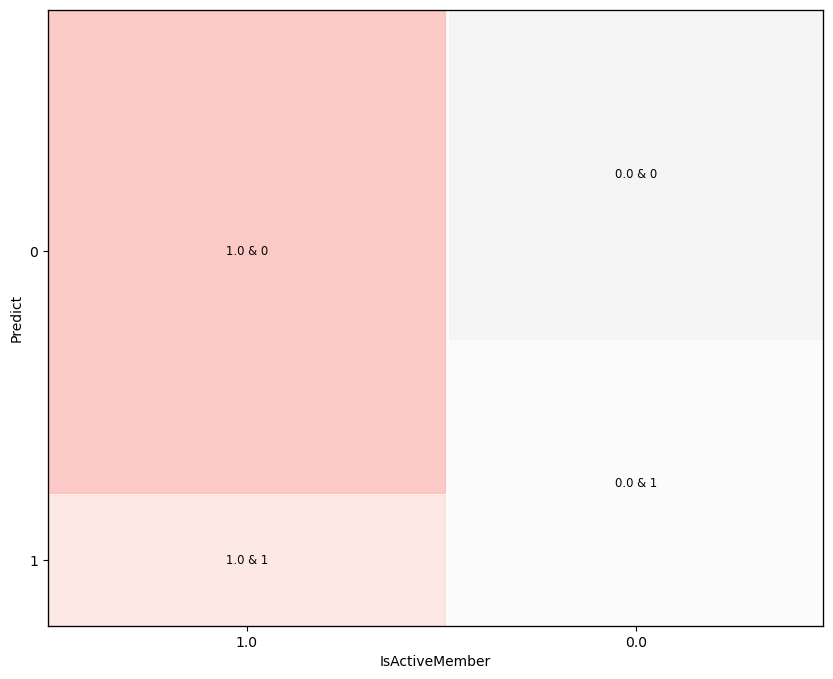

In [143]:
for column in cat_cols:
    create_mosaic_plot(result, column, 'Predict')

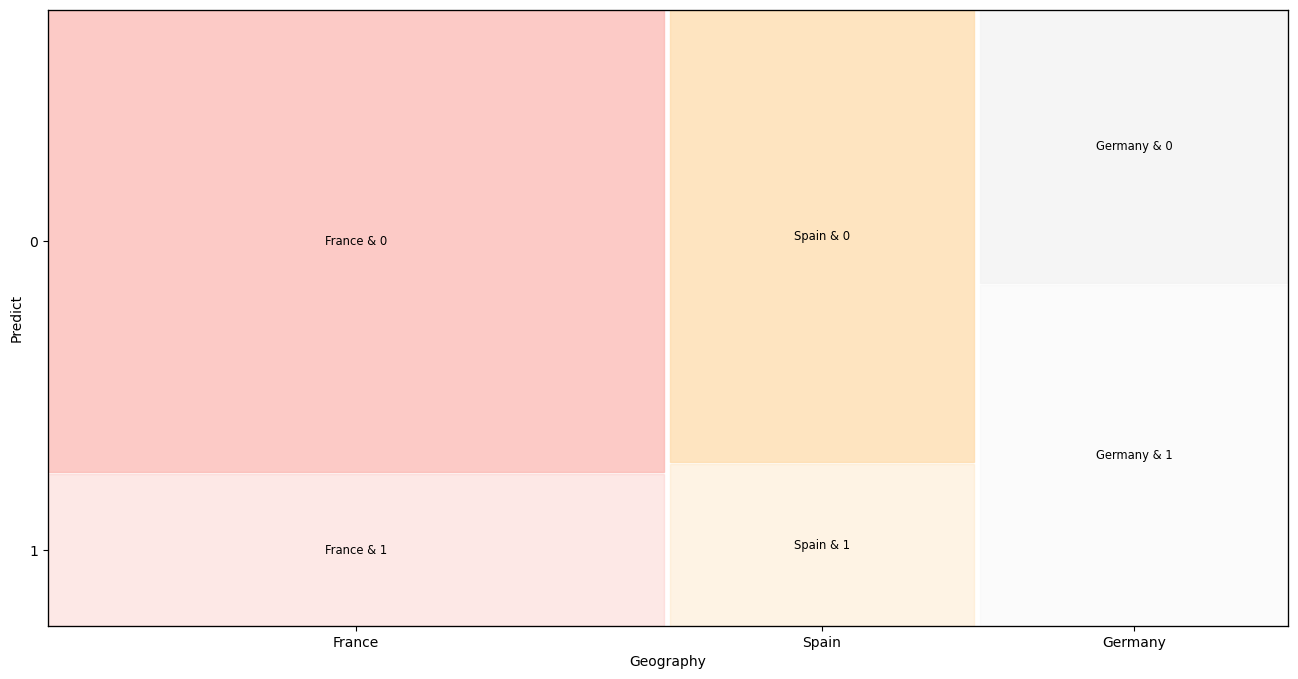

In [50]:
create_mosaic_plot(result, 'Geography', 'Predict')

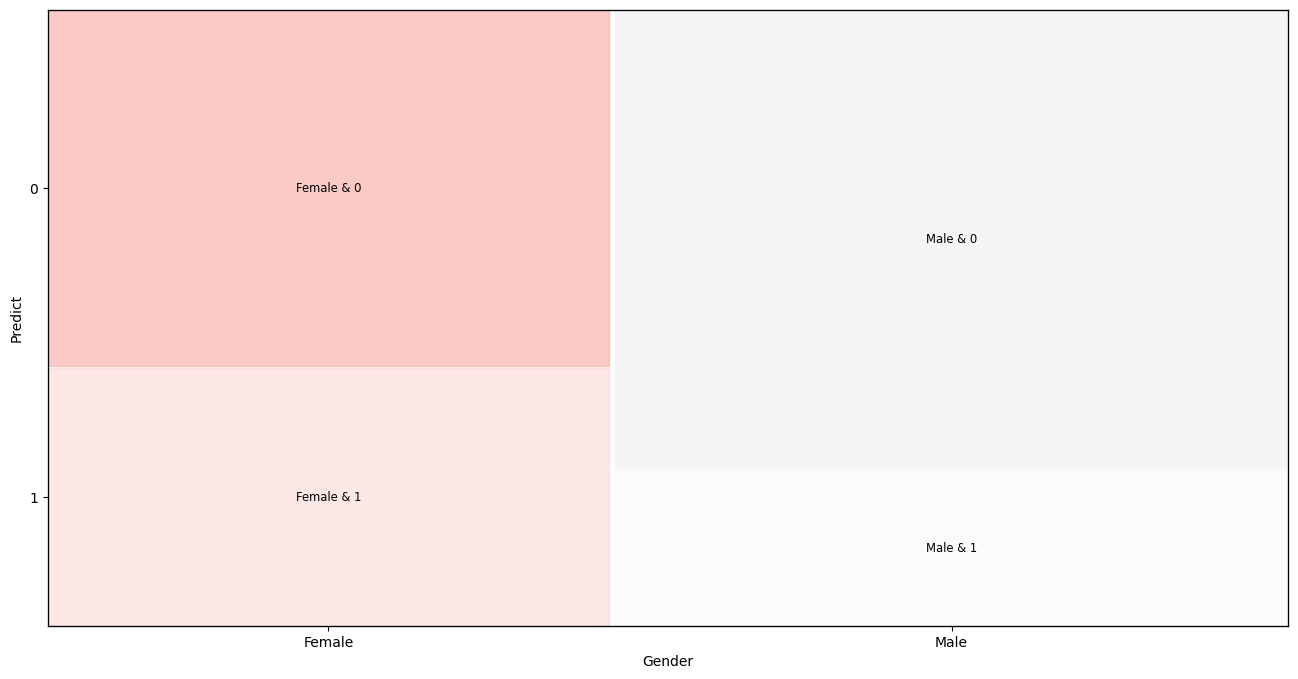

In [51]:
create_mosaic_plot(result, 'Gender', 'Predict')

### 이탈별 수치형 변수 분석

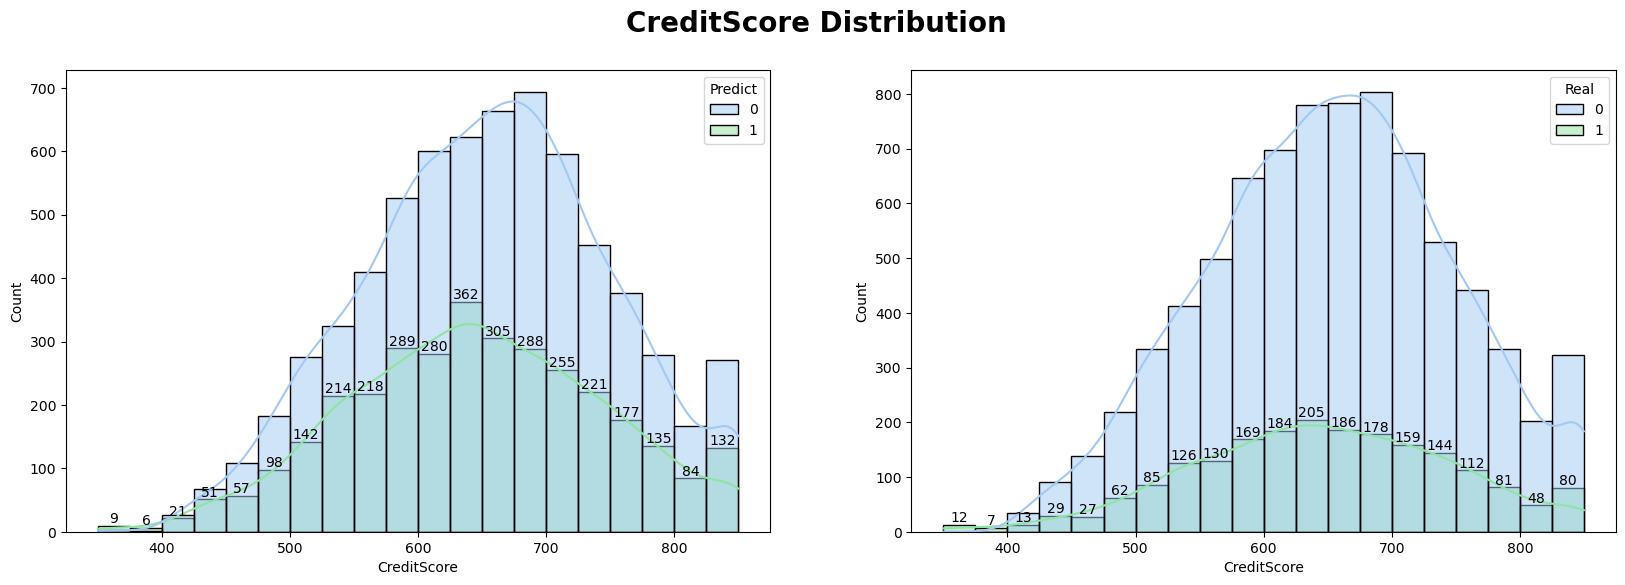

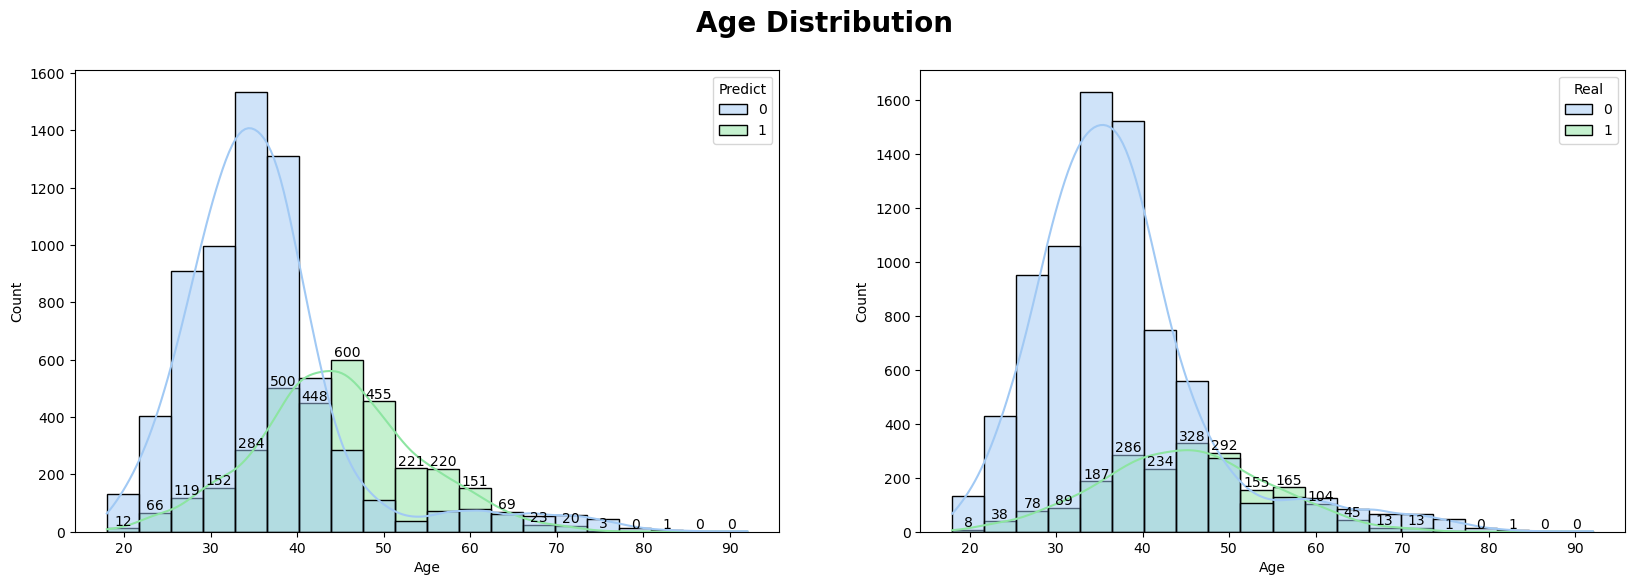

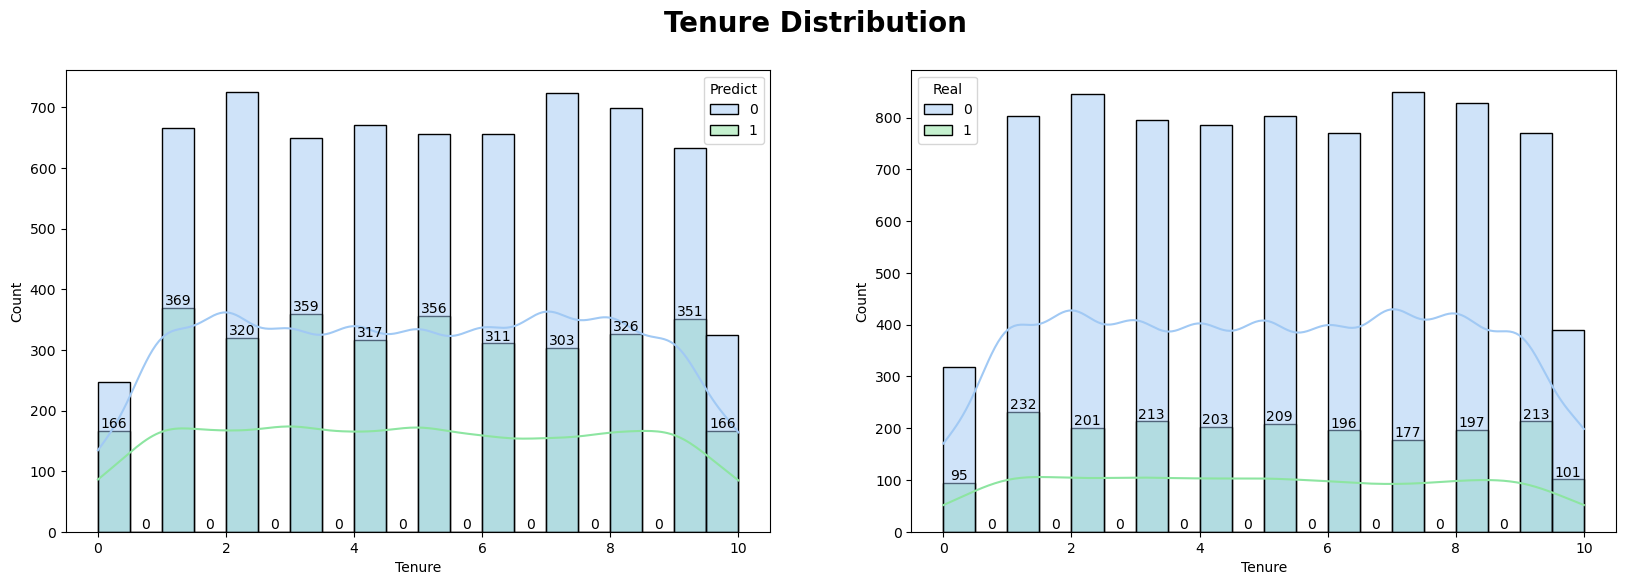

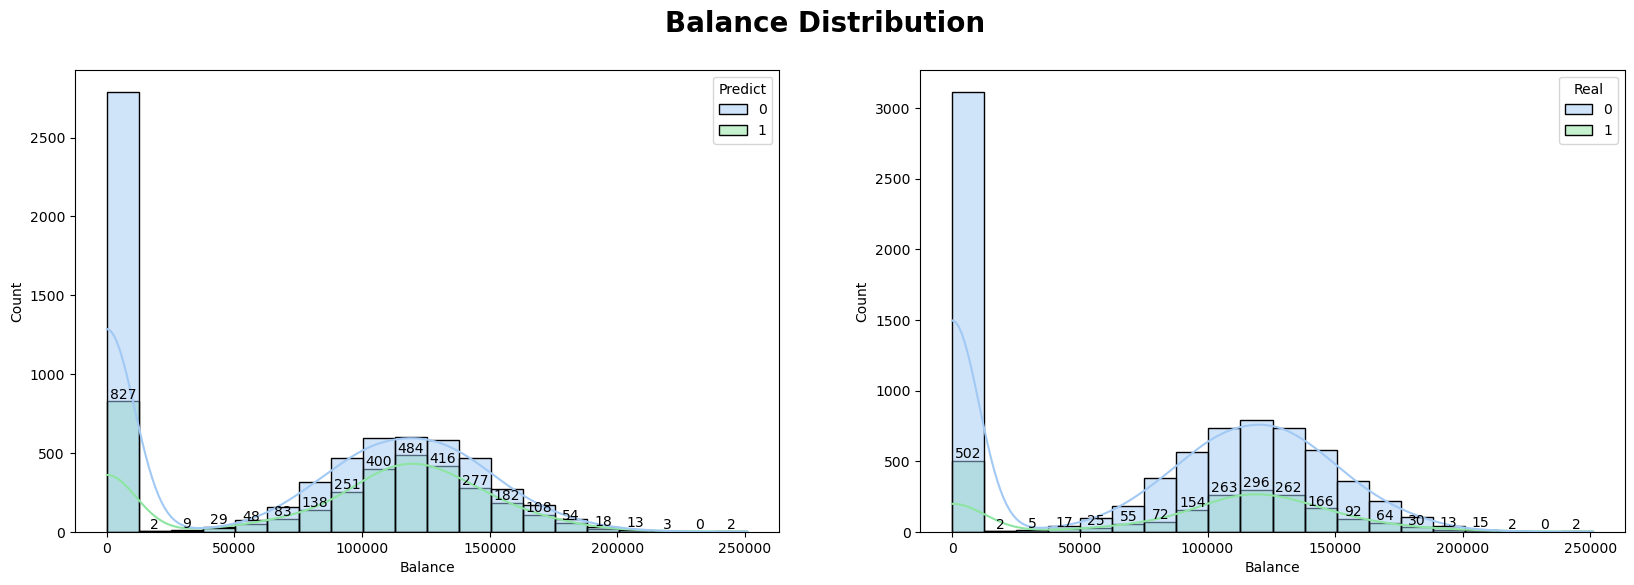

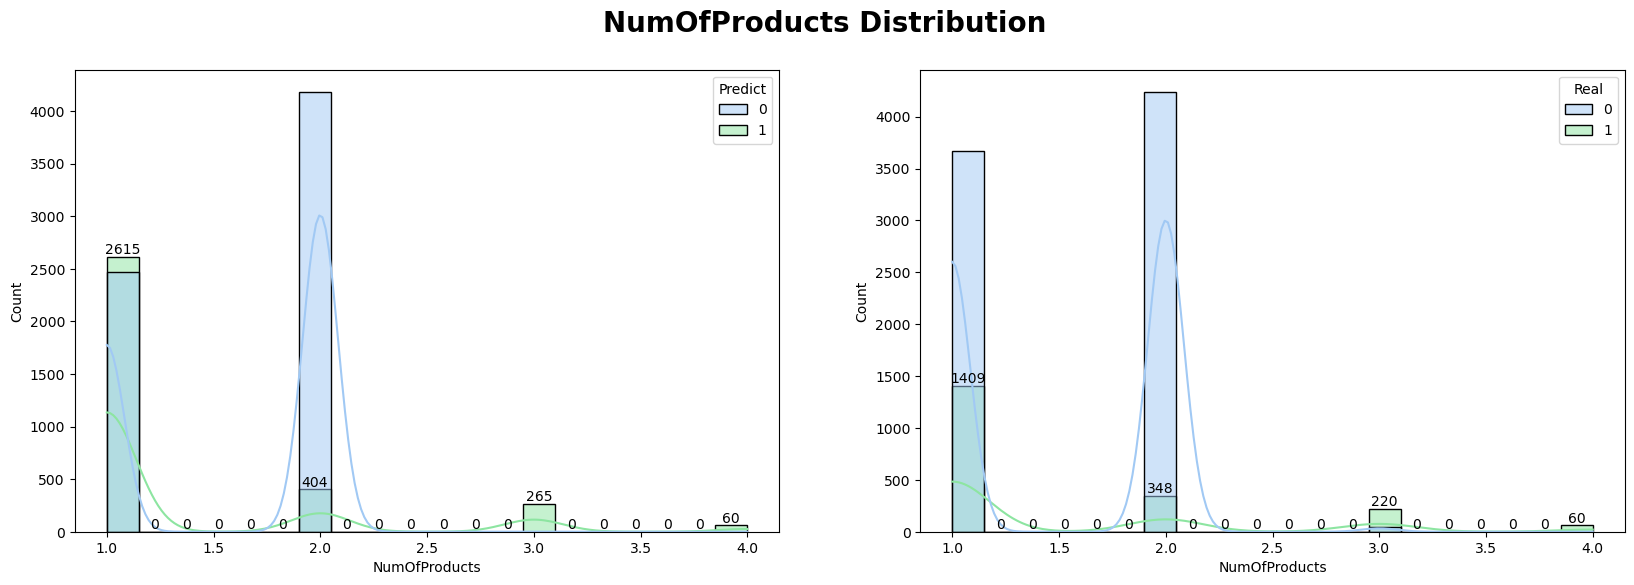

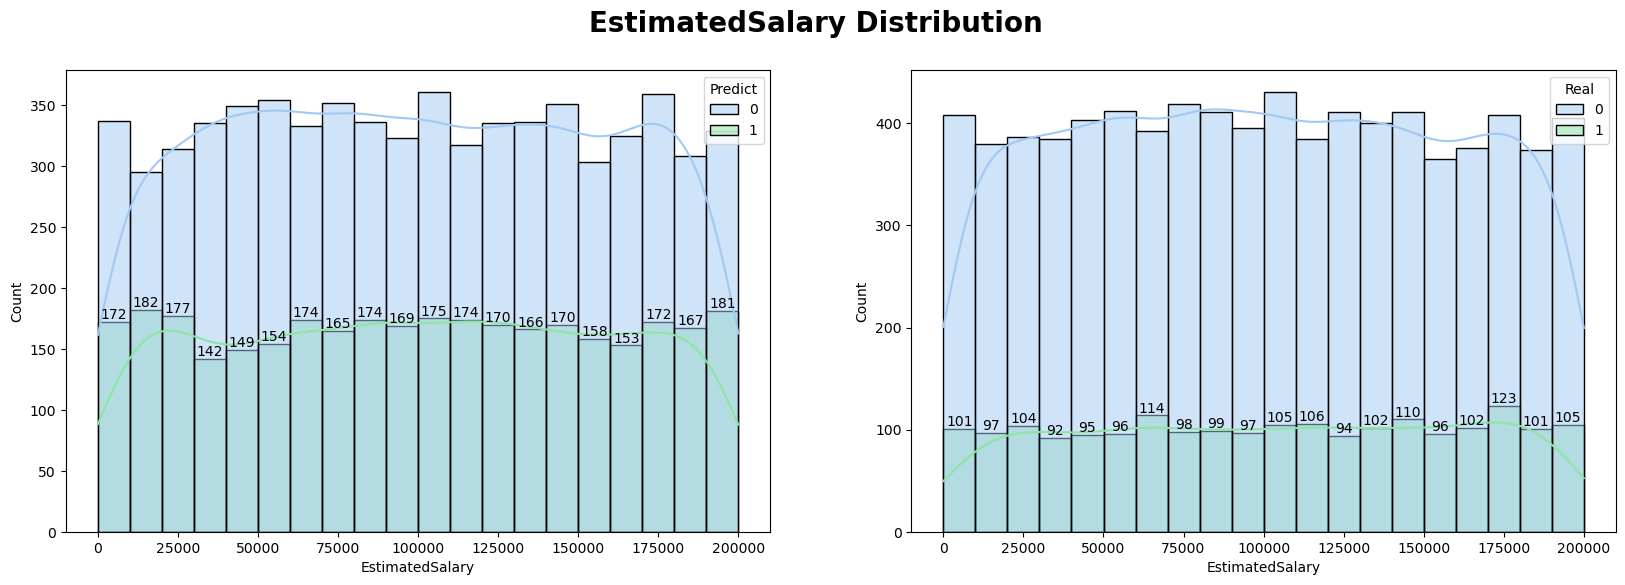

In [144]:
for column in num_cols:
    hues = ["Predict", "Real"]
    i = 0
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), width_ratios=[1, 1])

    for ax in axes:
        sns.histplot(x=column, hue=hues[i], data=result, bins=20, kde=True, palette="pastel6", ax=ax)
        # ax.bar_label(ax.containers[1], label_type='edge')
        ax.bar_label(ax.containers[0], label_type='edge')
        i+=1
    
    plt.suptitle(f'{column} Distribution', weight='bold', fontsize=20)
    plt.show()

- 수치형 변수 또한 특성 중요도에서 수치가 높았던 가입 상품 수(1개의 이탈 비율), 나이(40-50, 50-60), 잔고(100000-150000)의 이탈 비율이 많이 높아졌다

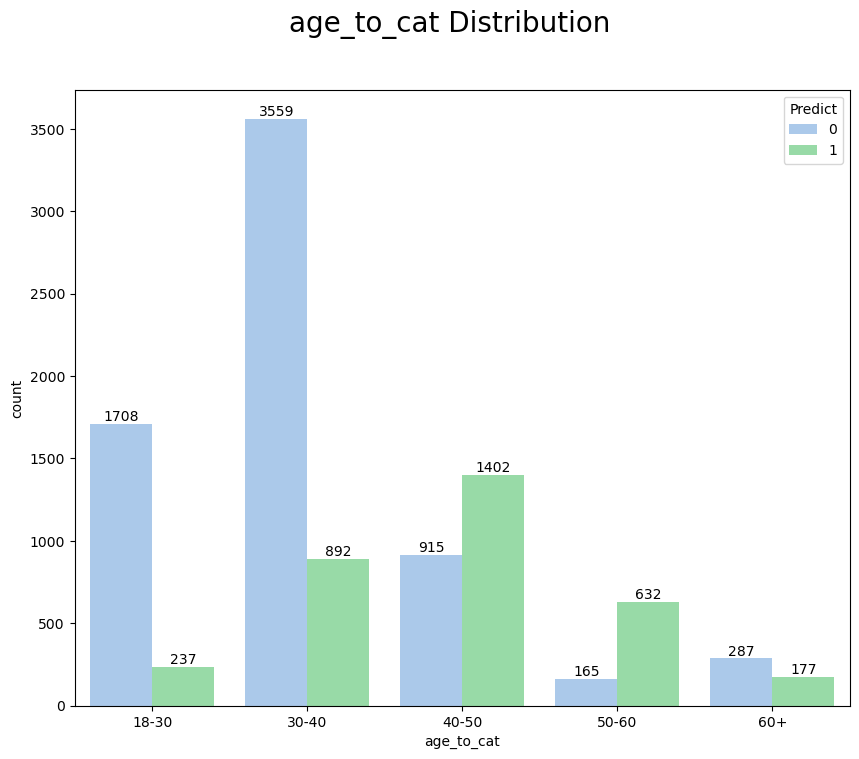

In [145]:
result['age_to_cat'] = pd.cut(result['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '30-40', '40-50', '50-60', '60+'])
fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(hue="Predict", x='age_to_cat', data=result, palette="pastel6",)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.suptitle('age_to_cat Distribution',fontsize=20)
plt.show()

### 컬럼과의 상관계수 확인

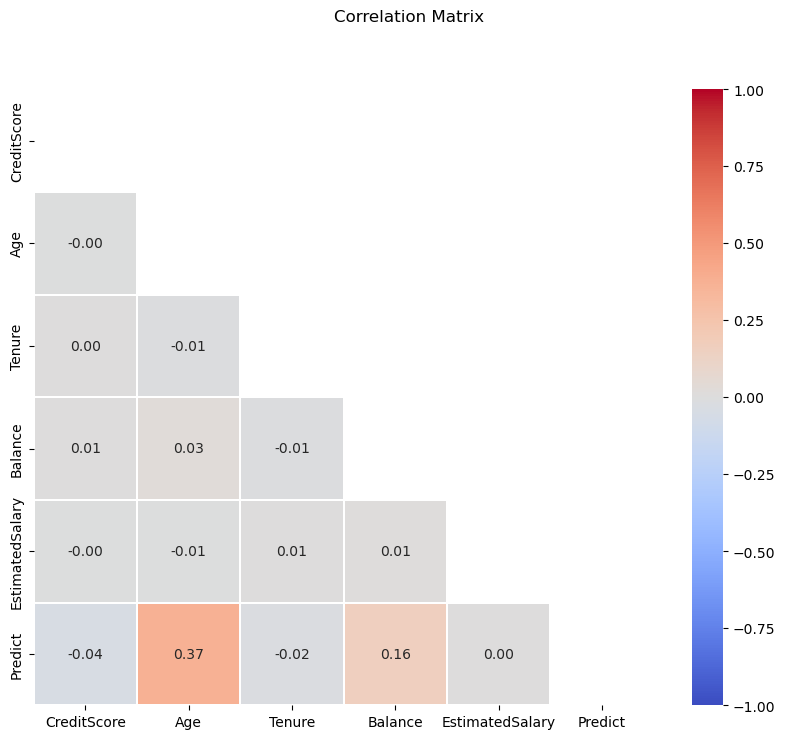

In [149]:
result_digit = result[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Predict']].copy()

corr_matrix = result_digit.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f,ax=plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix, mask=mask, annot=True, linewidths=.2, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.suptitle('Correlation Matrix')
plt.show()

- train 데이터에서 상관계수가 높았던 나이와 잔고의 상관계수가 조금 더 상승했다.

In [147]:
result_cat_digit = result[['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Predict']].copy()
geo_plus_gen = result[['Geography','Gender']].copy()
geo_plus_gen

,Geography,Gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
5,Spain,Male
...,...,...
9995,France,Male
9996,France,Male
9997,France,Female
9998,Germany,Male


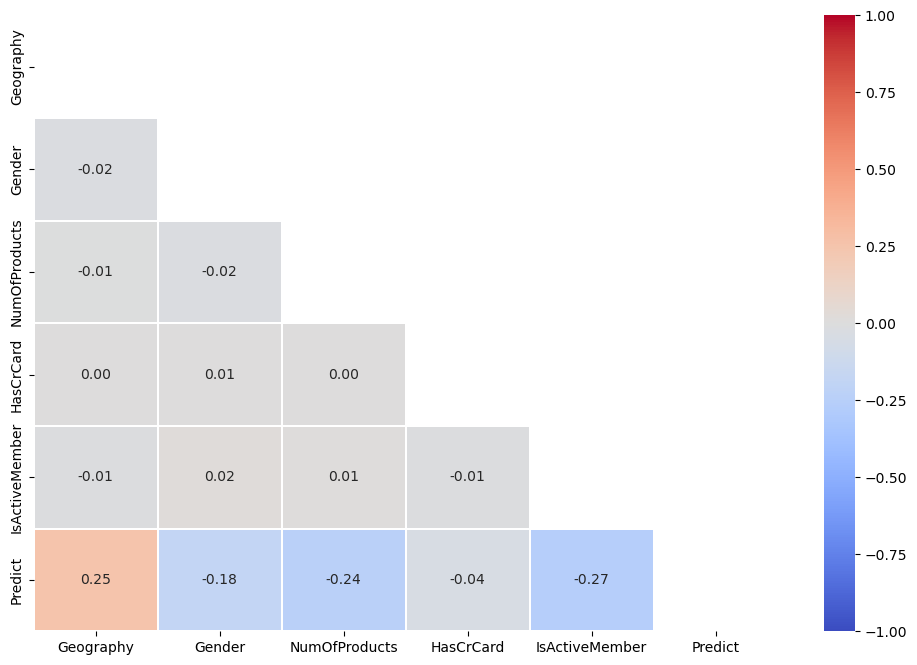

In [150]:
df_cat = geo_plus_gen.apply(lambda x: pd.factorize(x)[0])
df_cat_corr = pd.concat([df_cat, result_cat_digit],axis = 1).corr()

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df_cat_corr, dtype=bool))
ax = sns.heatmap(df_cat_corr, mask=mask, xticklabels=df_cat_corr.columns, yticklabels=df_cat_corr.columns, annot=True, fmt=".2f", linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

- train 데이터에서 상관계수가 높았던 거주지역, 성별, 가입 상품 수, 활성 멤버의 상관계수가 조금 더 상승했다.